In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
%matplotlib notebook
from PIL import Image
from sklearn.utils import shuffle



#pre-processing
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer



#modeling
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier




#CV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from numpy import array
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('791531.csv', encoding='latin-1')
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

### Intro

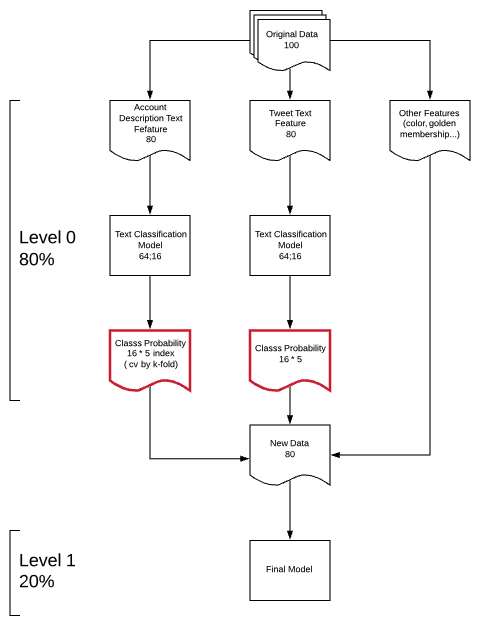

In [3]:
Image.open('screenshot3.png')

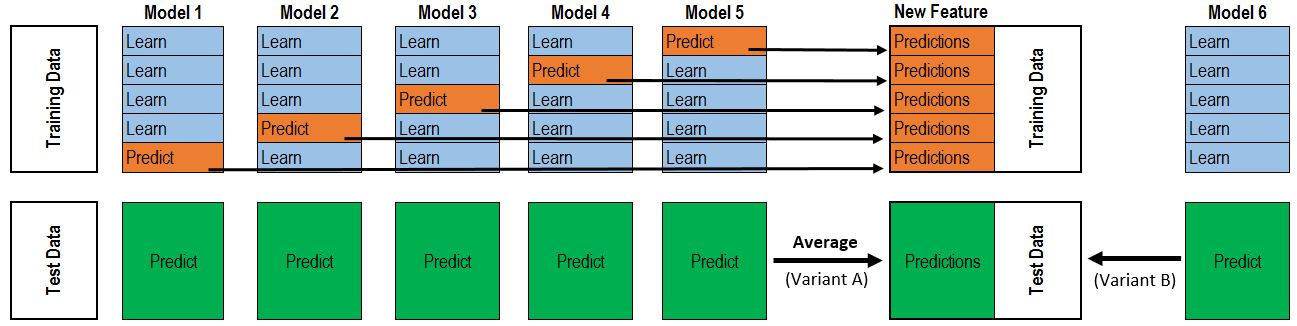

In [4]:
Image.open('screenshot4.png')

### A. Cleaning

### Crop

In [5]:
df = df[['text', 'description', 'sidebar_color', 'gender:confidence', 'gender']]
#the model's main purpose is detecting gender, so we didn't pick 'location' feature
df.dropna(inplace = True)
df.drop(df[(df['gender'] == 'unknown') | 
           (df['gender'] == 'brand')].index, inplace = True)
df.drop(df[df['gender:confidence'] != 1].index, inplace = True)


In [6]:
df.shape

(8766, 5)

In [7]:
df.head(1)

,text,description,sidebar_color,gender:confidence,gender
0,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.,FFFFFF,1.0,male


In [8]:
#two funcitons for normalization
def doc_features(doc):
    #HTML
    pattern = r"http\S+"
    documents = re.sub(pattern, " ", doc)
    
    #'-' letters
    documents = re.sub("[^a-zA-Z]"," ", doc)
    
    #To lower case
    words = documents.lower().split()
    
    #Stop words (nltk)
    stop = set(stopwords.words("english"))
    words = [w for w in words if not w in stop]
    
    #Stemmer & Return
    features = []
    stemmer = english_stemmer
    for word in words:
        features.append(stemmer.stem(word))
        
    return(features)
    
def text_cleaner(text):
    clean_text = []
    for i in text:
        clean_text.append(' '.join(doc_features(i)))
    
    return clean_text

In [9]:
df['text'] = text_cleaner(df['text']);
df['description'] = text_cleaner(df['description']);

In [10]:
del df['gender:confidence']

In [11]:
df

,text,description,sidebar_color,gender
0,robbi e respond critic win eddi edward worldti...,sing rhythm,FFFFFF,male
1,felt like friend live stori https co arng yhno...,author novel fill famili drama romanc,C0DEED,male
3,hi jordanspieth look url use ifttt typic see a...,mobil guy er shazam googl kleiner perkin yahoo...,C0DEED,male
4,watch neighbour sky catch neighb xxx xxx,ricki wilson best frontman kaiser chief best b...,0,female
5,ive seen peopl train lamp chair tvs etc https ...,know,0,female
...,...,...,...,...
20044,need ride home practic rain hard asf,love,C0DEED,female
20045,lookupondeath fine drink tea love,rp,C0DEED,female
20046,greg hardi good player get face dez bryant lea...,whatev like problem chargern foreverroy edm mu...,0,male
20047,miss peopl still never want see,teambarcelona look lost follow follow heart br...,C0DEED,male


### Map

In [12]:
df['gender'] = df['gender'].map({ 'male':1, 'female':0})

In [13]:
df.groupby('gender').count()[['sidebar_color']]

,sidebar_color
gender,
0,4616
1,4150


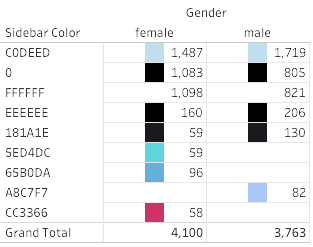

In [14]:
Image.open('screenshot1.png')
#This chart only display "sidebar_color" counts > 50;
#Except sidebar_color = 0, all the color display with real RGB

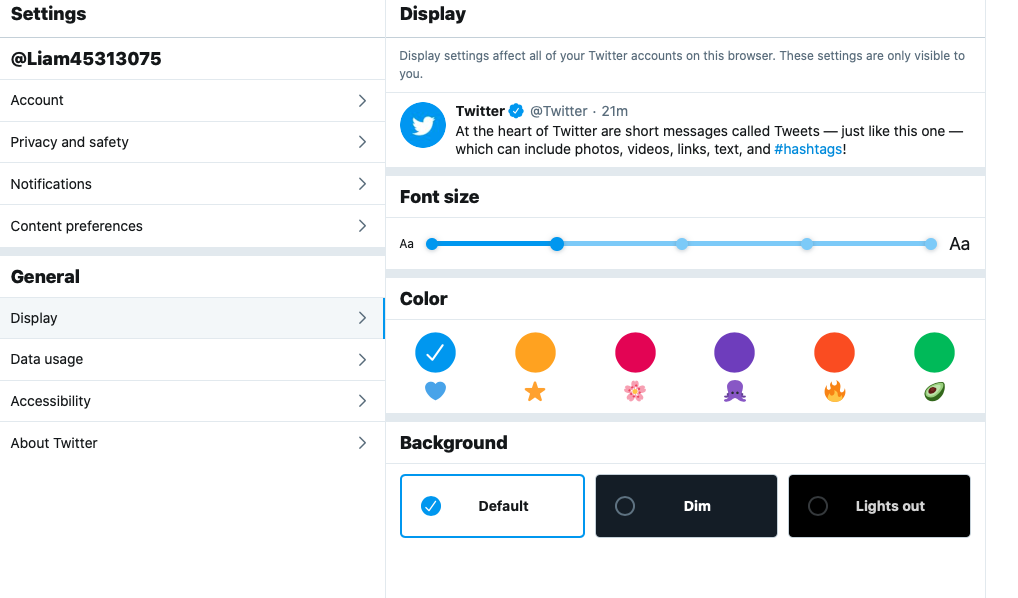

In [15]:
#By this chart, we hard to tell how sidebar color correlates to gender
#Moreover, current Twitter seems not allowing customized sidebar color 
#only 6 theme colors
Image.open('screenshot2.png')

### B. Preprocessing

In [16]:
#shuffle df and split train_test for level0 modeling
df = shuffle(df)
df.reset_index(drop=True, inplace= True)
df.head(5)

,text,description,sidebar_color,gender
0,drink sea water smirk reserv lordgrantham pull...,test make r n ge r,0,0
1,p employe pay ni privat school fee https co ph...,financi director sca group owner bicknel busi ...,C0DEED,1
2,think buy home want learn bit mortgag check pr...,residenti sale invest,C0DEED,1
3,live collxkelli broadcast younow https co tceu...,mde thank jordan bryan pleas rt link bio,FFFFFF,1
4,maggi purchas black news gonna back maggiindia...,student blogger friend awesom,F0A830,1


In [17]:
len(df)*0.8

7012.8

#we will utilize df1 for level 0 model training and df2 for level 1 testing

df1 = df[['text','description','gender']].loc[:7010]
df2 = df[['text','description','gender']].loc[7011:]

In [18]:
df_level0 = df[['text', 'description', 'gender']]

In [19]:
df_level0_train = df_level0[['text','description','gender']].loc[:7010]
df_level0_test = df_level0[['text','description','gender']].loc[7011:]

In [20]:
print (df_level0_train.shape, df_level0_test.shape)

(7011, 3) (1755, 3)


### C. Level 0 Modeling

In [21]:
# Feed df_level0

In [ ]:
def text_vec_convert(X_train, X_test, X_oof_test):
    #apply countvectorizer, deafult n-gram (1,1)
    vectorizer = CountVectorizer(ngram_range = (1,1))
    
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_oof_test = vectorizer.transform(X_oof_test)
    
    return X_train, X_test, X_oof_test


def MNB_modeling(X_train, y_train):
    clf = MultinomialNB(alpha = 1)
    clf.fit(X_train, y_train)
    return clf

def get_train_prediction(X, y, X_oof_test, df_train):
    '''
    Wrape up and process K-Fold validation, text_vector_convert, and MNB_modeling
    
    Output: Dataframe of train prob prediction & oof prob prediction (3 rows)
    '''
    
    #set up K-Fold loop & get index
    
    kf = KFold(n_splits = 10, shuffle = True)
    scores = []
    kfold_output_df = pd.DataFrame({'index':[], 'prob_female':[], 'prob_male':[] })
    oof_pred_df = pd.DataFrame({'kfold_batch':[],'index':[], 'prob_female':[], 'prob_male':[] })
    kfold_batch = 1
    
    for train_index, test_index in kf.split(df_train):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        print ('len(df):', len(df_train))
        print ('len(X_train):', len(X_train))
        print ('len(X_test):', len(X_test))
        
        #vector convert
        X_oof_test_temp = X_oof_test
        X_train, X_test, X_oof_test_temp = text_vec_convert(X_train, X_test, X_oof_test_temp)
          
        #feed in MNB
        clf = MNB_modeling(X_train, y_train)
        
        #get accuracy scores
        score = clf.score(X_test, y_test)
        scores.append(score)
        
        #get prediction and match with index;
        
        kfold_pred = clf.predict_proba(X_test)
        kfold_temp = pd.DataFrame({'index':j, 'prob_female':i[0], 'prob_male':i[1] } 
                               for i, j in zip(kfold_pred, test_index))
        kfold_output_df = kfold_output_df.append(kfold_temp, sort= True)
        
        
        print ('score for each iteration:', score)
        
        #utilize clf for oof_test set
        oof_pred = clf.predict_proba(X_oof_test_temp)
        oof_temp = pd.DataFrame({'kfold_batch':kfold_batch,'index':j, 'prob_female':i[0], 'prob_male':i[1] } 
                               for i, j in zip(oof_pred, range(X_oof_test.shape[0])))
        oof_pred_df = oof_pred_df.append(oof_temp, sort= True)
        kfold_batch += 1
        
    print ('-----------------------')
    print ('avg accuracy:', np.mean(scores))
    print ('-----------------------')
    
    output = {'dataframe': [kfold_pred, oof_pred_df]}
    return kfold_output_df, oof_pred_df

In [ ]:
kfold_text, oof_text = get_train_prediction(df_level0_train['text'], df_level0_train['gender']
                                   , df_level0_test['text'], df_level0_train)

In [ ]:
kfold_desc, oof_desc = get_train_prediction(df_level0_train['description'], df_level0_train['gender']
                                   , df_level0_test['description'], df_level0_train)

### Check & Clean K-Fold prediction

In [ ]:
kfold_text.shape

In [ ]:
#check duplicated data
print (kfold_text['index'].duplicated().sum())
print (kfold_desc['index'].duplicated().sum())

In [ ]:
kfold_text = kfold_text.sort_values(by=['index'])
kfold_text.head(5)

In [ ]:
kfold_desc = kfold_desc.sort_values(by=['index'])
kfold_desc.head(5)

In [ ]:
kfold_train_df = pd.merge(left= kfold_text, right= kfold_desc, left_on='index', right_on='index')
kfold_train_df.head(2) 

In [ ]:
kfold_train_df = kfold_train_df[['prob_male_x', 'prob_male_y']]
kfold_train_df.rename(columns = {'prob_male_x': 'p_male_text', 'prob_male_y': 'p_male_desc'}, inplace= True)

In [ ]:
kfold_train_df

### Check & Clean Test Prediction

In [ ]:
1755*5

In [ ]:
oof_desc.shape

In [ ]:
def avg_oof_scores(rows, df):
    gb = df.groupby('index') 
    df_group = [gb.get_group(x) for x in gb.groups]
    
    avg_scores = []
    for i in range(rows):
        avg_score = df_group[i]['prob_male'].mean()
        avg_scores.append(avg_score)
    return avg_scores

In [ ]:
oof_text_avg = avg_oof_scores(df_level0_test.shape[0], oof_text)
oof_desc_avg = avg_oof_scores(df_level0_test.shape[0], oof_desc)

In [ ]:
len(oof_desc_avg)

In [ ]:
oof_df = pd.DataFrame({'p_male_text':i, 'p_male_desc':j } 
                      for i, j in zip(oof_text_avg, oof_desc_avg))

In [ ]:
oof_df

### Merge Level 0 output to Level1 df

In [ ]:
df_level1 = kfold_train_df.append(oof_df, sort= False)

In [ ]:
df_level1.iloc[7009]

In [ ]:
df_level1.reset_index(drop= True, inplace= True)

In [ ]:
df_level1.head(1)

In [ ]:
df['gender'] = df['gender'].astype(str)

In [ ]:
df_level1['gender'] = df['gender']

In [ ]:
df_level1

### D. Level 1 Modeling

In [ ]:
X = df_level1[['p_male_text', 'p_male_desc']]
y = df_level1['gender']

In [ ]:
def simple_lv1(X, y):
    data, eval_data, target, eval_target = train_test_split(X, y, test_size=0.20,random_state=100)
    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        ('ridge',RidgeClassifier()),
        ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        ('random_forest',RandomForestClassifier()),
        ('svc',LinearSVC()),
        ('deep_nn',MLPClassifier()),
        ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        #('MNB', MultinomialNB(alpha = 1))
    ]
    
    scores=[]
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(data,target)
        score = pipe.score(eval_data, eval_target)
        scores.append(score)
        
    return (scores)

In [ ]:
m1_scores = simple_lv1(X, y)

In [ ]:
m1_scores

## Method 2 

In [ ]:
#Image.open('screenshot5.png')

In [ ]:
#the chart of data flow
Image.open('screenshot6.png')

### A. Pre-processing

In [28]:
m2_df_level0 = df[['text', 'description', 'gender']]

In [29]:
m2_df_level0.head(2)

,text,description,gender
0,drink sea water smirk reserv lordgrantham pull...,test make r n ge r,0
1,p employe pay ni privat school fee https co ph...,financi director sca group owner bicknel busi ...,1


In [38]:
m2_df_level0_train = m2_df_level0[['text','description','gender']].loc[:7010]
m2_df_level0_test = m2_df_level0[['text','description','gender']].loc[7011:]

In [25]:
print (m2_df_level0_train.shape, m2_df_level0_test.shape)

(7011, 3) (1755, 3)


### B. Level 0 Modeling

In [26]:
m2_df_level0_train.head(3)

,text,description,gender
0,elimin risk amp attain higher achiev avoid dea...,market http co il mj xzsq work global recogn c...,1
1,eu vote net neutral tomorrow could serious rep...,student journalist staff writer puremzin inter...,1
2,noth like come home boolin,live motto yolo bout everyday til kyri,0


In [35]:
def text_vec_convert2(X_train, X_test):
    vectorizer = CountVectorizer(ngram_range = (1,1))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test

In [36]:
def m2_lv0_modeling(X_train, y_train):
    
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train,
                                                                        test_size=0.20, random_state=100)
    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        ('random_forest',RandomForestClassifier()),
        ('deep_nn',MLPClassifier()),
        ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        ('MNB', MultinomialNB(alpha = 1))
        ]
    
    pipes=[]
    model_name = []
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_sub_train,y_sub_train)
        print(model[0], 'accuracy:', pipe.score(X_sub_test, y_sub_test))
        pipes.append(pipe)
        model_name.append(model[0])
    #return trained classfiers
    return pipes, model_name

In [37]:
def m2_lv0_wrap(X_train, X_test, y_train):
    
    #text vectorize
    X_train, X_test = text_vec_convert2(X_train, X_test)
    
    #modeling & get clf
    clfs, clf_names = m2_lv0_modeling(X_train, y_train)
    
    #apply X_test to clf for prediction
    prediction_df = pd.DataFrame({'clf_name':[], 'prob_male':[]})
    for i , j in zip(clfs, clf_names):
        pred = i.predict_proba(X_test)
        prediction_df_temp = pd.DataFrame({'clf_name': j, 'prob_male':pred[m, 1] } for m in range(len(pred)))
        prediction_df = prediction_df.append(prediction_df_temp, sort= False)
    #pivot prediction output
    prediction_df = prediction_df.pivot(index= None, columns= 'clf_name', values= 'prob_male')
    return prediction_df
        
    

In [ ]:
# y_test remains secret to clfs
m2_prediction_text = m2_lv0_wrap(m2_df_level0_train['text'], m2_df_level0_test['text'],
                                 m2_df_level0_train['gender'])

m2_prediction_desc = m2_lv0_wrap(m2_df_level0_train['description'], m2_df_level0_test['description'],
                                 m2_df_level0_train['gender'])

### P(male) df form Level0 model

In [ ]:
m2_prediction_text.head(3)

In [ ]:
m2_prediction_desc.head(3)

In [ ]:
m2_df_level0_test['gender'].reset_index(drop= True, inplace= True)

In [ ]:
m2_df_level1 = pd.concat([m2_prediction_text, m2_prediction_desc, m2_df_level0_test['gender']], axis= 1)
pd.set_option('display.max_colwidth', -1)
m2_df_level1.head(5)

### C. Level 1 Modeling

In [ ]:
m2_df_level1.columns

In [ ]:
m2_X = m2_df_level1[['MNB', 'deep_nn', 'elasticnet', 'knn', 'lasso', 'logistic','random_forest']]
m2_y = m2_df_level1['gender']

In [ ]:
m2_X.shape

In [ ]:
m2_scores = simple_lv1(m2_X, m2_y)
m2_scores

## Method 1 & Method 2 Comparasion

In [ ]:
sum(m1_scores)/len(m1_scores)

In [ ]:
sum(m2_scores)/len(m2_scores)

### Method 1 performs silghtly better than Method 2, however we only generate and apply 20% (1755) prediction for M2 training

## Method 2 - revision

In [416]:
def m2_outer_loop(X, y, df):
    
    pred_df = pd.DataFrame({'index':[], 'clf_name':[], 'prob_male':[]})
    kf = KFold(n_splits = 4, shuffle = True)
    
    k = 1
    
    
    for train_index, test_index in kf.split(df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        print ('-----------', 'Fold Loop%r'%k, '----------')
        print ('Train len:', len(X_train))
        print ('Test len:', len(X_test))
        
        vectorizer = CountVectorizer(ngram_range = (1,1))
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        
        #Train and get predictions from weak learners
        pred_df_temp = m2_inner_loop(X_train, y_train, X_test, test_index)
        pred_df = pred_df.append(pred_df_temp, sort= False)
        k+=1
        
    return pred_df

In [417]:
def m2_inner_loop(X_train, y_train, X_test, test_index):
     
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train,
                                                                        test_size=0.50, random_state=100)
    
    print ('Sub_train len:', X_sub_train.shape[0])
    print ('Sub_test len:', X_sub_test.shape[0])

    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        #('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        #('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        #('random_forest',RandomForestClassifier()),
        #('deep_nn',MLPClassifier()),
        #('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        ('MNB', MultinomialNB(alpha = 1))
        ]
    
    prediction_df = pd.DataFrame({'index':[], 'clf_name':[], 'prob_male':[]})
    
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_sub_train,y_sub_train)
        print(model[0],'test acc score:',pipe.score(X_sub_test, y_sub_test))
        
        #inner loop prediction
        #50% of train
        pred_sub_test = pipe.predict_proba(X_sub_test)
      
        pred_sub_test_df = pd.DataFrame({'index':y_sub_test.index[m], 'clf_name': model[0], 
                                         'prob_male':pred_sub_test[m, 1] } for m in range(X_sub_test.shape[0]))
        pred_test = pipe.predict_proba(X_test)                                
        pred_test_df = pd.DataFrame({'index':test_index[m], 'clf_name': model[0], 
                                     'prob_male':pred_test[m, 1] } for m in range(X_test.shape[0]))
        pred_df_temp = pd.concat([pred_sub_test_df, pred_test_df], ignore_index=True)
        prediction_df = prediction_df.append(pred_df_temp, sort = True)
        print('output pred from each inner loop', prediction_df.shape[0])
        
    return prediction_df

In [418]:
def m2_lv0_wrap_2(X, y, df):
    
    #get predictions
    pred_df = m2_outer_loop(X, y, df)
    print ('-----------------------------')
    print ('final output df', pred_df.shape)

    #pivot prediction output
    #pred_df = pred_df.pivot(index= None, columns= 'clf_name', values= 'prob_male')
    return pred_df

In [419]:
aa = m2_lv0_wrap_2(m2_df_level0['text'], m2_df_level0['gender'], m2_df_level0);

----------- Fold Loop1 ----------
Train len: 6574
Test len: 2192
Sub_train len: 3287
Sub_test len: 3287
logistic test acc score: 0.5701247337998174
output pred from each inner loop 5479
MNB test acc score: 0.5914207484027989
output pred from each inner loop 10958
----------- Fold Loop2 ----------
Train len: 6574
Test len: 2192
Sub_train len: 3287
Sub_test len: 3287
logistic test acc score: 0.5695162762397323
output pred from each inner loop 5479
MNB test acc score: 0.588378460602373
output pred from each inner loop 10958
----------- Fold Loop3 ----------
Train len: 6575
Test len: 2191
Sub_train len: 3287
Sub_test len: 3288
logistic test acc score: 0.5748175182481752
output pred from each inner loop 5479
MNB test acc score: 0.5936739659367397
output pred from each inner loop 10958
----------- Fold Loop4 ----------
Train len: 6575
Test len: 2191
Sub_train len: 3287
Sub_test len: 3288
logistic test acc score: 0.5736009732360098
output pred from each inner loop 5479
MNB test acc score: 0.5

In [420]:
aa = aa.reset_index(drop = True)

In [387]:
aa['clf_name'].value_counts()

MNB         21916
logistic    21916
Name: clf_name, dtype: int64

In [422]:
grouped_df = aa.groupby('index')

for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

       index  clf_name  prob_male
3287     0.0  logistic   0.568557
8766     0.0       MNB   0.317806
13916    0.0  logistic   0.287710
19395    0.0       MNB   0.034585
24878    0.0  logistic   0.940956
30357    0.0       MNB   0.790837
35836    0.0  logistic   0.190464
41315    0.0       MNB   0.059690 


       index  clf_name  prob_male
2958     1.0  logistic   0.618013
8437     1.0       MNB   0.475507
12136    1.0  logistic   0.583276
17615    1.0       MNB   0.745461
25204    1.0  logistic   0.326345
30683    1.0       MNB   0.407591
34056    1.0  logistic   0.549760
39535    1.0       MNB   0.842217 


       index  clf_name  prob_male
1178     2.0  logistic   0.805337
6657     2.0       MNB   0.917396
23098    2.0  logistic   0.450771
28577    2.0       MNB   0.602965
36162    2.0  logistic   0.736153
41641    2.0       MNB   0.813137 


       index  clf_name  prob_male
36163    3.0  logistic   0.503568
41642    3.0       MNB   0.510015 


       index  clf_name  prob_male
14

41178   68.0       MNB   0.480875 


       index  clf_name  prob_male
14264   69.0  logistic   0.624522
19743   69.0       MNB   0.511963
24741   69.0  logistic   0.544715
30220   69.0       MNB   0.516732
34477   69.0  logistic   0.333357
39956   69.0       MNB   0.181594 


       index  clf_name  prob_male
25220   70.0  logistic   0.403009
30699   70.0       MNB   0.177172 


       index  clf_name  prob_male
568     71.0  logistic   0.551721
6047    71.0       MNB   0.671992
25221   71.0  logistic   0.420471
30700   71.0       MNB   0.258716 


       index  clf_name  prob_male
2821    72.0  logistic   0.150732
8300    72.0       MNB   0.012299
11526   72.0  logistic   0.478115
17005   72.0       MNB   0.739075
23519   72.0  logistic   0.767177
28998   72.0       MNB   0.802870
36177   72.0  logistic   0.414624
41656   72.0       MNB   0.348810 


       index  clf_name  prob_male
3306    73.0  logistic   0.434405
8785    73.0       MNB   0.237915
13779   73.0  logistic   0.600407

41322  142.0       MNB   0.922908 


       index  clf_name  prob_male
3328   143.0  logistic   0.785551
8807   143.0       MNB   0.388354
13517  143.0  logistic   0.070281
18996  143.0       MNB   0.006081
24958  143.0  logistic   0.273604
30437  143.0       MNB   0.040176
35437  143.0  logistic   0.304638
40916  143.0       MNB   0.046534 


       index  clf_name  prob_male
25242  144.0  logistic   0.202882
30721  144.0       MNB   0.023981 


      index  clf_name  prob_male
3329  145.0  logistic   0.293029
8808  145.0       MNB   0.067286 


       index  clf_name  prob_male
3204   146.0  logistic   0.263299
8683   146.0       MNB   0.187482
13149  146.0  logistic   0.475241
18628  146.0       MNB   0.434428
23089  146.0  logistic   0.304708
28568  146.0       MNB   0.069842
36194  146.0  logistic   0.328455
41673  146.0       MNB   0.649384 


       index  clf_name  prob_male
991    147.0  logistic   0.464557
6470   147.0       MNB   0.227269
11153  147.0  logistic   0.328802
16

30735  213.0       MNB   0.143621 


       index  clf_name  prob_male
778    214.0  logistic   0.270082
6257   214.0       MNB   0.052370
25257  214.0  logistic   0.329356
30736  214.0       MNB   0.155053 


       index  clf_name  prob_male
2596   215.0  logistic   0.720055
8075   215.0       MNB   0.950626
14294  215.0  logistic   0.343529
19773  215.0       MNB   0.630165 


       index  clf_name  prob_male
36213  216.0  logistic   0.651571
41692  216.0       MNB   0.967562 


       index  clf_name  prob_male
14295  217.0  logistic   0.314969
19774  217.0       MNB   0.390049 


       index  clf_name  prob_male
2110   218.0  logistic   0.332303
7589   218.0       MNB   0.096674
13518  218.0  logistic   0.609792
18997  218.0       MNB   0.353482
36214  218.0  logistic   0.249716
41693  218.0       MNB   0.176309 


       index  clf_name  prob_male
3348   219.0  logistic   0.541837
8827   219.0       MNB   0.721816
13901  219.0  logistic   0.600356
19380  219.0       MNB   0.445

41708  264.0       MNB   0.292241 


       index  clf_name  prob_male
22118  265.0  logistic   0.065619
27597  265.0       MNB   0.002045
36230  265.0  logistic   0.065962
41709  265.0       MNB   0.027746 


       index  clf_name  prob_male
23561  266.0  logistic   0.678047
29040  266.0       MNB   0.628749
36231  266.0  logistic   0.628842
41710  266.0       MNB   0.819399 


       index  clf_name  prob_male
2583   267.0  logistic   0.493646
8062   267.0       MNB   0.521464
14122  267.0  logistic   0.410567
19601  267.0       MNB   0.430625
25269  267.0  logistic   0.531292
30748  267.0       MNB   0.657630 


       index  clf_name  prob_male
14008  268.0  logistic   0.270822
19487  268.0       MNB   0.238254
36232  268.0  logistic   0.228067
41711  268.0       MNB   0.157960 


       index  clf_name  prob_male
22     269.0  logistic   0.629273
5501   269.0       MNB   0.620068
36233  269.0  logistic   0.645804
41712  269.0       MNB   0.804061 


       index  clf_name  prob_m

19804  335.0       MNB   0.345958 


       index  clf_name  prob_male
14326  336.0  logistic   0.157454
19805  336.0       MNB   0.068056
34550  336.0  logistic   0.282739
40029  336.0       MNB   0.141636 


       index  clf_name  prob_male
1455   337.0  logistic   0.726663
6934   337.0       MNB   0.877853
12413  337.0  logistic   0.745097
17892  337.0       MNB   0.991803
24927  337.0  logistic   0.764940
30406  337.0       MNB   0.684323
36256  337.0  logistic   0.643958
41735  337.0       MNB   0.643266 


       index  clf_name  prob_male
14327  338.0  logistic   0.240515
19806  338.0       MNB   0.230903
23216  338.0  logistic   0.537036
28695  338.0       MNB   0.517803 


       index  clf_name  prob_male
14328  339.0  logistic   0.394643
19807  339.0       MNB   0.277055
23366  339.0  logistic   0.547055
28845  339.0       MNB   0.645713 


       index  clf_name  prob_male
3007   340.0  logistic   0.750077
8486   340.0       MNB   0.781827
22109  340.0  logistic   0.756551

30782  396.0       MNB   0.384444 


       index  clf_name  prob_male
3121   397.0  logistic   0.016525
8600   397.0       MNB   0.000680
14339  397.0  logistic   0.044380
19818  397.0       MNB   0.001635
21936  397.0  logistic   0.048471
27415  397.0       MNB   0.004815
34757  397.0  logistic   0.146802
40236  397.0       MNB   0.010973 


       index  clf_name  prob_male
2442   398.0  logistic   0.551721
7921   398.0       MNB   0.178508
36276  398.0  logistic   0.375459
41755  398.0       MNB   0.054183 


       index  clf_name  prob_male
368    399.0  logistic   0.342164
5847   399.0       MNB   0.245841
14340  399.0  logistic   0.278492
19819  399.0       MNB   0.030867 


       index  clf_name  prob_male
25304  400.0  logistic   0.283175
30783  400.0       MNB   0.017107
36120  400.0  logistic   0.220697
41599  400.0       MNB   0.009187 


       index  clf_name  prob_male
652    401.0  logistic   0.147100
6131   401.0       MNB   0.054239
14010  401.0  logistic   0.094795

41771  445.0       MNB   0.984054 


       index  clf_name  prob_male
12647  446.0  logistic   0.135865
18126  446.0       MNB   0.046137
25313  446.0  logistic   0.254487
30792  446.0       MNB   0.071466 


       index  clf_name  prob_male
14351  447.0  logistic   0.439351
19830  447.0       MNB   0.608299
23122  447.0  logistic   0.235797
28601  447.0       MNB   0.107671 


       index  clf_name  prob_male
24014  448.0  logistic   0.372002
29493  448.0       MNB   0.543328
36293  448.0  logistic   0.411002
41772  448.0       MNB   0.319624 


       index  clf_name  prob_male
306    449.0  logistic   0.559349
5785   449.0       MNB   0.433178
14352  449.0  logistic   0.587452
19831  449.0       MNB   0.516315
22633  449.0  logistic   0.420569
28112  449.0       MNB   0.354671
34354  449.0  logistic   0.707275
39833  449.0       MNB   0.646373 


       index  clf_name  prob_male
3387   450.0  logistic   0.412491
8866   450.0       MNB   0.431905
12542  450.0  logistic   0.582758

41783  508.0       MNB   0.082836 


       index  clf_name  prob_male
2532   509.0  logistic   0.634549
8011   509.0       MNB   0.638097
13488  509.0  logistic   0.700434
18967  509.0       MNB   0.745108
24557  509.0  logistic   0.337399
30036  509.0       MNB   0.411080
36305  509.0  logistic   0.768905
41784  509.0       MNB   0.741681 


       index  clf_name  prob_male
12170  510.0  logistic   0.778863
17649  510.0       MNB   0.939493
25331  510.0  logistic   0.858841
30810  510.0       MNB   0.957584
34455  510.0  logistic   0.711107
39934  510.0       MNB   0.692222 


       index  clf_name  prob_male
14370  511.0  logistic   0.408550
19849  511.0       MNB   0.314224
24401  511.0  logistic   0.418907
29880  511.0       MNB   0.350993
34243  511.0  logistic   0.493257
39722  511.0       MNB   0.375147 


       index  clf_name  prob_male
11909  512.0  logistic   0.543132
17388  512.0       MNB   0.414604
24450  512.0  logistic   0.200641
29929  512.0       MNB   0.164743
36

41240  571.0       MNB   0.570611 


       index  clf_name  prob_male
3094   572.0  logistic   0.067689
8573   572.0       MNB   0.017986
11208  572.0  logistic   0.033021
16687  572.0       MNB   0.001494
25346  572.0  logistic   0.060559
30825  572.0       MNB   0.001889
33886  572.0  logistic   0.055933
39365  572.0       MNB   0.003324 


       index  clf_name  prob_male
14391  573.0  logistic   0.170911
19870  573.0       MNB   0.082616 


       index  clf_name  prob_male
13696  574.0  logistic   0.194937
19175  574.0       MNB   0.097646
25347  574.0  logistic   0.266509
30826  574.0       MNB   0.134518 


       index  clf_name  prob_male
3419   575.0  logistic   0.586870
8898   575.0       MNB   0.879538
33781  575.0  logistic   0.352002
39260  575.0       MNB   0.600193 


       index  clf_name  prob_male
25348  576.0  logistic   0.152375
30827  576.0       MNB   0.003875 


       index  clf_name  prob_male
23376  577.0  logistic   0.438183
28855  577.0       MNB   0.534

19884  635.0       MNB   0.602699 


       index  clf_name  prob_male
13964  636.0  logistic   0.556225
19443  636.0       MNB   0.368035
36330  636.0  logistic   0.395462
41809  636.0       MNB   0.262025 


       index  clf_name  prob_male
14406  637.0  logistic   0.179272
19885  637.0       MNB   0.072272 


       index  clf_name  prob_male
1843   638.0  logistic   0.543395
7322   638.0       MNB   0.146065
23946  638.0  logistic   0.381691
29425  638.0       MNB   0.362075
36331  638.0  logistic   0.430810
41810  638.0       MNB   0.214816 


       index  clf_name  prob_male
36332  639.0  logistic   0.594016
41811  639.0       MNB   0.463226 


       index  clf_name  prob_male
25362  640.0  logistic   0.355681
30841  640.0       MNB   0.312496
35524  640.0  logistic   0.386516
41003  640.0       MNB   0.256485 


       index  clf_name  prob_male
2449   641.0  logistic   0.155598
7928   641.0       MNB   0.100949
14407  641.0  logistic   0.086177
19886  641.0       MNB   0.008

41825  687.0       MNB   0.004291 


       index  clf_name  prob_male
1780   688.0  logistic   0.983696
7259   688.0       MNB   0.999855
14420  688.0  logistic   0.934159
19899  688.0       MNB   0.997410
22149  688.0  logistic   0.930912
27628  688.0       MNB   0.998884 


       index  clf_name  prob_male
1134   689.0  logistic   0.346912
6613   689.0       MNB   0.569238
22721  689.0  logistic   0.511751
28200  689.0       MNB   0.522083
36347  689.0  logistic   0.754209
41826  689.0       MNB   0.750119 


       index  clf_name  prob_male
25371  690.0  logistic   0.518564
30850  690.0       MNB   0.665313
33612  690.0  logistic   0.401655
39091  690.0       MNB   0.296685 


       index  clf_name  prob_male
3448   691.0  logistic   0.458937
8927   691.0       MNB   0.301828
12836  691.0  logistic   0.153598
18315  691.0       MNB   0.112333 


       index  clf_name  prob_male
14421  692.0  logistic   0.471133
19900  692.0       MNB   0.053705 


       index  clf_name  prob_m

8950  755.0       MNB   0.655104 


       index  clf_name  prob_male
1333   756.0  logistic   0.574946
6812   756.0       MNB   0.328641
14437  756.0  logistic   0.592890
19916  756.0       MNB   0.470878 


       index  clf_name  prob_male
3472   757.0  logistic   0.263634
8951   757.0       MNB   0.048784
12227  757.0  logistic   0.274820
17706  757.0       MNB   0.031147
24433  757.0  logistic   0.336940
29912  757.0       MNB   0.371711 


       index  clf_name  prob_male
3473   758.0  logistic   0.512133
8952   758.0       MNB   0.613527
14191  758.0  logistic   0.633545
19670  758.0       MNB   0.468319
35125  758.0  logistic   0.616186
40604  758.0       MNB   0.654562 


       index  clf_name  prob_male
3240   759.0  logistic   0.470446
8719   759.0       MNB   0.663878
14438  759.0  logistic   0.350596
19917  759.0       MNB   0.429637
22673  759.0  logistic   0.670179
28152  759.0       MNB   0.611466 


       index  clf_name  prob_male
2540   760.0  logistic   0.343827


41858  825.0       MNB   0.038672 


       index  clf_name  prob_male
2815   826.0  logistic   0.412277
8294   826.0       MNB   0.394137
11210  826.0  logistic   0.408254
16689  826.0       MNB   0.412540
25396  826.0  logistic   0.332537
30875  826.0       MNB   0.045067 


       index  clf_name  prob_male
323    827.0  logistic   0.509073
5802   827.0       MNB   0.389535
14455  827.0  logistic   0.705824
19934  827.0       MNB   0.845257
22207  827.0  logistic   0.766059
27686  827.0       MNB   0.859107 


       index  clf_name  prob_male
3193   828.0  logistic   0.117026
8672   828.0       MNB   0.040441
12792  828.0  logistic   0.352661
18271  828.0       MNB   0.388893
25397  828.0  logistic   0.177756
30876  828.0       MNB   0.066702
32986  828.0  logistic   0.157779
38465  828.0       MNB   0.160697 


       index  clf_name  prob_male
23395  829.0  logistic   0.180108
28874  829.0       MNB   0.012264
36380  829.0  logistic   0.075802
41859  829.0       MNB   0.005605 



38403  882.0       MNB   0.363126 


       index  clf_name  prob_male
13945  883.0  logistic   0.252534
19424  883.0       MNB   0.118864
22573  883.0  logistic   0.253118
28052  883.0       MNB   0.036393
36396  883.0  logistic   0.276826
41875  883.0       MNB   0.184753 


       index  clf_name  prob_male
576    884.0  logistic   0.693363
6055   884.0       MNB   0.884845
36397  884.0  logistic   0.636205
41876  884.0       MNB   0.741302 


       index  clf_name  prob_male
341    885.0  logistic   0.462337
5820   885.0       MNB   0.722286
22495  885.0  logistic   0.342523
27974  885.0       MNB   0.649332
36398  885.0  logistic   0.475020
41877  885.0       MNB   0.357310 


       index  clf_name  prob_male
14470  886.0  logistic   0.716113
19949  886.0       MNB   0.647704
22771  886.0  logistic   0.751300
28250  886.0       MNB   0.703278
35741  886.0  logistic   0.611499
41220  886.0       MNB   0.563901 


       index  clf_name  prob_male
168    887.0  logistic   0.107692

41894  958.0       MNB   0.397741 


       index  clf_name  prob_male
2914   959.0  logistic   0.568966
8393   959.0       MNB   0.780029
14488  959.0  logistic   0.557407
19967  959.0       MNB   0.628036
23688  959.0  logistic   0.392791
29167  959.0       MNB   0.324285
35370  959.0  logistic   0.320061
40849  959.0       MNB   0.153915 


       index  clf_name  prob_male
861    960.0  logistic   0.339121
6340   960.0       MNB   0.101618
14062  960.0  logistic   0.184886
19541  960.0       MNB   0.187724
25437  960.0  logistic   0.167559
30916  960.0       MNB   0.034089
35581  960.0  logistic   0.225890
41060  960.0       MNB   0.015387 


       index  clf_name  prob_male
578    961.0  logistic   0.627050
6057   961.0       MNB   0.241832
25438  961.0  logistic   0.525313
30917  961.0       MNB   0.427964
34386  961.0  logistic   0.740876
39865  961.0       MNB   0.828537 


       index  clf_name  prob_male
14489  962.0  logistic   0.558344
19968  962.0       MNB   0.488874
34

41915  1032.0       MNB   0.009838 


        index  clf_name  prob_male
2671   1033.0  logistic   0.936140
8150   1033.0       MNB   0.995645
11335  1033.0  logistic   0.684181
16814  1033.0       MNB   0.879597
36437  1033.0  logistic   0.831543
41916  1033.0       MNB   0.951279 


        index  clf_name  prob_male
3530   1034.0  logistic   0.547538
9009   1034.0       MNB   0.314651
34929  1034.0  logistic   0.162065
40408  1034.0       MNB   0.010034 


        index  clf_name  prob_male
1278   1035.0  logistic   0.348706
6757   1035.0       MNB   0.181115
25461  1035.0  logistic   0.155182
30940  1035.0       MNB   0.026259
34197  1035.0  logistic   0.124658
39676  1035.0       MNB   0.031176 


        index  clf_name  prob_male
3531   1036.0  logistic   0.577927
9010   1036.0       MNB   0.164246
11989  1036.0  logistic   0.600029
17468  1036.0       MNB   0.394614
22950  1036.0  logistic   0.643538
28429  1036.0       MNB   0.428621 


        index  clf_name  prob_male
2822 

41927  1092.0       MNB   0.765182 


        index  clf_name  prob_male
36449  1093.0  logistic   0.310040
41928  1093.0       MNB   0.015561 


       index  clf_name  prob_male
3549  1094.0  logistic   0.352944
9028  1094.0       MNB   0.156154 


        index  clf_name  prob_male
14518  1095.0  logistic   0.674410
19997  1095.0       MNB   0.588924
34194  1095.0  logistic   0.762504
39673  1095.0       MNB   0.531339 


        index  clf_name  prob_male
152    1096.0  logistic   0.542803
5631   1096.0       MNB   0.211954
14519  1096.0  logistic   0.245879
19998  1096.0       MNB   0.042963 


        index  clf_name  prob_male
2579   1097.0  logistic   0.194614
8058   1097.0       MNB   0.037857
14520  1097.0  logistic   0.168081
19999  1097.0       MNB   0.064530 


        index  clf_name  prob_male
14521  1098.0  logistic   0.669333
20000  1098.0       MNB   0.692412 


        index  clf_name  prob_male
14522  1099.0  logistic   0.473085
20001  1099.0       MNB   0.482246
22

30960  1151.0       MNB   0.086747 


        index  clf_name  prob_male
599    1152.0  logistic   0.617486
6078   1152.0       MNB   0.488796
25110  1152.0  logistic   0.505258
30589  1152.0       MNB   0.436312
36463  1152.0  logistic   0.848147
41942  1152.0       MNB   0.845791 


        index  clf_name  prob_male
3568   1153.0  logistic   0.492371
9047   1153.0       MNB   0.418850
12342  1153.0  logistic   0.268657
17821  1153.0       MNB   0.179533
23931  1153.0  logistic   0.489630
29410  1153.0       MNB   0.404864
34644  1153.0  logistic   0.366546
40123  1153.0       MNB   0.288271 


        index  clf_name  prob_male
3569   1154.0  logistic   0.644769
9048   1154.0       MNB   0.741740
24407  1154.0  logistic   0.331084
29886  1154.0       MNB   0.406850
34919  1154.0  logistic   0.304471
40398  1154.0       MNB   0.454393 


        index  clf_name  prob_male
2808   1155.0  logistic   0.793886
8287   1155.0       MNB   0.379044
14537  1155.0  logistic   0.729354
20016  1

41954  1220.0       MNB   0.448950 


        index  clf_name  prob_male
3582   1221.0  logistic   0.490885
9061   1221.0       MNB   0.485046
25004  1221.0  logistic   0.742519
30483  1221.0       MNB   0.873403 


        index  clf_name  prob_male
36476  1222.0  logistic   0.489032
41955  1222.0       MNB   0.479946 


        index  clf_name  prob_male
3583   1223.0  logistic   0.696843
9062   1223.0       MNB   0.583376
25176  1223.0  logistic   0.762630
30655  1223.0       MNB   0.591159
35542  1223.0  logistic   0.636620
41021  1223.0       MNB   0.594364 


        index  clf_name  prob_male
3255   1224.0  logistic   0.498681
8734   1224.0       MNB   0.478429
14561  1224.0  logistic   0.378905
20040  1224.0       MNB   0.236021 


        index  clf_name  prob_male
14562  1225.0  logistic   0.258246
20041  1225.0       MNB   0.312610
34190  1225.0  logistic   0.404591
39669  1225.0       MNB   0.358896 


        index  clf_name  prob_male
14563  1226.0  logistic   0.588361
20

        index  clf_name  prob_male
14581  1284.0  logistic   0.622962
20060  1284.0       MNB   0.205651
23207  1284.0  logistic   0.535004
28686  1284.0       MNB   0.467924
34011  1284.0  logistic   0.297405
39490  1284.0       MNB   0.138288 


        index  clf_name  prob_male
3600   1285.0  logistic   0.599918
9079   1285.0       MNB   0.935611
24522  1285.0  logistic   0.538672
30001  1285.0       MNB   0.892117
35890  1285.0  logistic   0.362355
41369  1285.0       MNB   0.817443 


        index  clf_name  prob_male
12405  1286.0  logistic   0.583241
17884  1286.0       MNB   0.849321
25515  1286.0  logistic   0.546860
30994  1286.0       MNB   0.870749
33083  1286.0  logistic   0.294010
38562  1286.0       MNB   0.491158 


        index  clf_name  prob_male
1286   1287.0  logistic   0.678819
6765   1287.0       MNB   0.984254
12444  1287.0  logistic   0.909801
17923  1287.0       MNB   0.996764
36486  1287.0  logistic   0.915996
41965  1287.0       MNB   0.970851 


        

41014  1356.0       MNB   0.026278 


        index  clf_name  prob_male
3107   1357.0  logistic   0.381269
8586   1357.0       MNB   0.356381
36499  1357.0  logistic   0.085337
41978  1357.0       MNB   0.018372 


        index  clf_name  prob_male
14606  1358.0  logistic   0.252765
20085  1358.0       MNB   0.162863
25125  1358.0  logistic   0.620810
30604  1358.0       MNB   0.495696 


        index  clf_name  prob_male
876    1359.0  logistic   0.227970
6355   1359.0       MNB   0.076857
14607  1359.0  logistic   0.224875
20086  1359.0       MNB   0.132640
23613  1359.0  logistic   0.218249
29092  1359.0       MNB   0.088675
32926  1359.0  logistic   0.243202
38405  1359.0       MNB   0.195599 


        index  clf_name  prob_male
25529  1360.0  logistic   0.377741
31008  1360.0       MNB   0.173178 


        index  clf_name  prob_male
3621   1361.0  logistic   0.236257
9100   1361.0       MNB   0.119725
12652  1361.0  logistic   0.720588
18131  1361.0       MNB   0.902562
35985

41142  1431.0       MNB   0.310591 


        index  clf_name  prob_male
14622  1432.0  logistic   0.575566
20101  1432.0       MNB   0.858305
34882  1432.0  logistic   0.584300
40361  1432.0       MNB   0.881436 


        index  clf_name  prob_male
12594  1433.0  logistic   0.356718
18073  1433.0       MNB   0.290255
22457  1433.0  logistic   0.452914
27936  1433.0       MNB   0.288376
36514  1433.0  logistic   0.111588
41993  1433.0       MNB   0.079774 


        index  clf_name  prob_male
14222  1434.0  logistic   0.507190
19701  1434.0       MNB   0.481007
25550  1434.0  logistic   0.507410
31029  1434.0       MNB   0.460752 


        index  clf_name  prob_male
1250   1435.0  logistic   0.306025
6729   1435.0       MNB   0.156514
14623  1435.0  logistic   0.191917
20102  1435.0       MNB   0.206725
23671  1435.0  logistic   0.386925
29150  1435.0       MNB   0.249568 


        index  clf_name  prob_male
2785   1436.0  logistic   0.272962
8264   1436.0       MNB   0.073874
23802

30274  1504.0       MNB   0.294070 


        index  clf_name  prob_male
14644  1505.0  logistic   0.313875
20123  1505.0       MNB   0.263299
23899  1505.0  logistic   0.185566
29378  1505.0       MNB   0.096198
32889  1505.0  logistic   0.203062
38368  1505.0       MNB   0.064438 


        index  clf_name  prob_male
3655   1506.0  logistic   0.231497
9134   1506.0       MNB   0.071650
12408  1506.0  logistic   0.313712
17887  1506.0       MNB   0.095228
22934  1506.0  logistic   0.210608
28413  1506.0       MNB   0.047591
35484  1506.0  logistic   0.391819
40963  1506.0       MNB   0.201887 


        index  clf_name  prob_male
2533   1507.0  logistic   0.350386
8012   1507.0       MNB   0.069748
14645  1507.0  logistic   0.079436
20124  1507.0       MNB   0.016586
21990  1507.0  logistic   0.042029
27469  1507.0       MNB   0.004597
35521  1507.0  logistic   0.191611
41000  1507.0       MNB   0.065315 


        index  clf_name  prob_male
1935   1508.0  logistic   0.242914
7414   1

38580  1576.0       MNB   0.453691 


        index  clf_name  prob_male
3674   1577.0  logistic   0.375648
9153   1577.0       MNB   0.405165
33574  1577.0  logistic   0.100434
39053  1577.0       MNB   0.024105 


        index  clf_name  prob_male
25585  1578.0  logistic   0.538450
31064  1578.0       MNB   0.288512 


        index  clf_name  prob_male
2773   1579.0  logistic   0.117928
8252   1579.0       MNB   0.045868
14662  1579.0  logistic   0.352344
20141  1579.0       MNB   0.065889
33156  1579.0  logistic   0.209811
38635  1579.0       MNB   0.089526 


        index  clf_name  prob_male
3675   1580.0  logistic   0.727318
9154   1580.0       MNB   0.888287
11934  1580.0  logistic   0.266268
17413  1580.0       MNB   0.258074
35395  1580.0  logistic   0.413906
40874  1580.0       MNB   0.504784 


        index  clf_name  prob_male
36554  1581.0  logistic   0.437012
42033  1581.0       MNB   0.146196 


        index  clf_name  prob_male
3676   1582.0  logistic   0.525416
91

42045  1648.0       MNB   0.964751 


        index  clf_name  prob_male
793    1649.0  logistic   0.113827
6272   1649.0       MNB   0.031353
14681  1649.0  logistic   0.087061
20160  1649.0       MNB   0.038011
24643  1649.0  logistic   0.029340
30122  1649.0       MNB   0.003967
33034  1649.0  logistic   0.343828
38513  1649.0       MNB   0.073722 


        index  clf_name  prob_male
14682  1650.0  logistic   0.400225
20161  1650.0       MNB   0.584041
25193  1650.0  logistic   0.508718
30672  1650.0       MNB   0.634285 


        index  clf_name  prob_male
22437  1651.0  logistic   0.258543
27916  1651.0       MNB   0.103309
36567  1651.0  logistic   0.522314
42046  1651.0       MNB   0.156590 


        index  clf_name  prob_male
540    1652.0  logistic   0.382436
6019   1652.0       MNB   0.163363
25601  1652.0  logistic   0.235467
31080  1652.0       MNB   0.283877
33145  1652.0  logistic   0.307786
38624  1652.0       MNB   0.124344 


        index  clf_name  prob_male
25602

31093  1701.0       MNB   0.809114 


        index  clf_name  prob_male
14694  1702.0  logistic   0.645265
20173  1702.0       MNB   0.532274 


        index  clf_name  prob_male
14695  1703.0  logistic   0.211593
20174  1703.0       MNB   0.035056
24838  1703.0  logistic   0.143156
30317  1703.0       MNB   0.050309
33572  1703.0  logistic   0.212511
39051  1703.0       MNB   0.058934 


        index  clf_name  prob_male
14230  1704.0  logistic   0.523954
19709  1704.0       MNB   0.657433
24985  1704.0  logistic   0.303095
30464  1704.0       MNB   0.030272
36579  1704.0  logistic   0.549126
42058  1704.0       MNB   0.655954 


        index  clf_name  prob_male
14696  1705.0  logistic   0.420845
20175  1705.0       MNB   0.234303
24267  1705.0  logistic   0.843972
29746  1705.0       MNB   0.721020
33092  1705.0  logistic   0.085303
38571  1705.0       MNB   0.117544 


        index  clf_name  prob_male
11479  1706.0  logistic   0.444036
16958  1706.0       MNB   0.410067
36580

42076  1776.0       MNB   0.632766 


        index  clf_name  prob_male
3731   1777.0  logistic   0.467472
9210   1777.0       MNB   0.293244
22795  1777.0  logistic   0.410946
28274  1777.0       MNB   0.635366 


        index  clf_name  prob_male
25629  1778.0  logistic   0.633182
31108  1778.0       MNB   0.504053 


        index  clf_name  prob_male
14190  1779.0  logistic   0.360762
19669  1779.0       MNB   0.258300
25630  1779.0  logistic   0.110834
31109  1779.0       MNB   0.009904 


        index  clf_name  prob_male
987    1780.0  logistic   0.817357
6466   1780.0       MNB   0.967571
13988  1780.0  logistic   0.330280
19467  1780.0       MNB   0.354823
25631  1780.0  logistic   0.925331
31110  1780.0       MNB   0.927369
33763  1780.0  logistic   0.809346
39242  1780.0       MNB   0.975192 


        index  clf_name  prob_male
3732   1781.0  logistic   0.338258
9211   1781.0       MNB   0.274531
35728  1781.0  logistic   0.225811
41207  1781.0       MNB   0.132442 


  

9229  1851.0       MNB   0.523159 


        index  clf_name  prob_male
2928   1852.0  logistic   0.249719
8407   1852.0       MNB   0.200093
14738  1852.0  logistic   0.721283
20217  1852.0       MNB   0.810027
24857  1852.0  logistic   0.346946
30336  1852.0       MNB   0.223224
33077  1852.0  logistic   0.549031
38556  1852.0       MNB   0.495934 


        index  clf_name  prob_male
401    1853.0  logistic   0.116305
5880   1853.0       MNB   0.122039
14739  1853.0  logistic   0.094826
20218  1853.0       MNB   0.006797
23014  1853.0  logistic   0.400376
28493  1853.0       MNB   0.631184
34565  1853.0  logistic   0.199387
40044  1853.0       MNB   0.188757 


        index  clf_name  prob_male
12387  1854.0  logistic   0.688163
17866  1854.0       MNB   0.613264
36616  1854.0  logistic   0.431636
42095  1854.0       MNB   0.702935 


        index  clf_name  prob_male
1065   1855.0  logistic   0.644562
6544   1855.0       MNB   0.674513
12700  1855.0  logistic   0.351984
18179  18

42115  1913.0       MNB   0.482608 


        index  clf_name  prob_male
749    1914.0  logistic   0.981598
6228   1914.0       MNB   0.982111
36637  1914.0  logistic   0.705015
42116  1914.0       MNB   0.589436 


        index  clf_name  prob_male
672    1915.0  logistic   0.122602
6151   1915.0       MNB   0.080899
24966  1915.0  logistic   0.054975
30445  1915.0       MNB   0.027403
36638  1915.0  logistic   0.175815
42117  1915.0       MNB   0.047005 


        index  clf_name  prob_male
13075  1916.0  logistic   0.254000
18554  1916.0       MNB   0.364587
25656  1916.0  logistic   0.527848
31135  1916.0       MNB   0.309423
36003  1916.0  logistic   0.237953
41482  1916.0       MNB   0.124797 


        index  clf_name  prob_male
13310  1917.0  logistic   0.551999
18789  1917.0       MNB   0.586450
25657  1917.0  logistic   0.437396
31136  1917.0       MNB   0.411080
35532  1917.0  logistic   0.440359
41011  1917.0       MNB   0.492096 


        index  clf_name  prob_male
3766 

31151  1982.0       MNB   0.975903 


        index  clf_name  prob_male
2460   1983.0  logistic   0.427436
7939   1983.0       MNB   0.256903
14774  1983.0  logistic   0.318665
20253  1983.0       MNB   0.134377
23581  1983.0  logistic   0.415557
29060  1983.0       MNB   0.317568
35903  1983.0  logistic   0.460730
41382  1983.0       MNB   0.479946 


        index  clf_name  prob_male
3779   1984.0  logistic   0.386239
9258   1984.0       MNB   0.314431
12271  1984.0  logistic   0.785992
17750  1984.0       MNB   0.971456
35338  1984.0  logistic   0.753273
40817  1984.0       MNB   0.950926 


        index  clf_name  prob_male
14775  1985.0  logistic   0.414263
20254  1985.0       MNB   0.361207
23981  1985.0  logistic   0.389897
29460  1985.0       MNB   0.279670 


        index  clf_name  prob_male
3780   1986.0  logistic   0.155666
9259   1986.0       MNB   0.104748
22341  1986.0  logistic   0.446422
27820  1986.0       MNB   0.258116
34750  1986.0  logistic   0.191338
40229  1

31171  2052.0       MNB   0.154332 


        index  clf_name  prob_male
3799   2053.0  logistic   0.382394
9278   2053.0       MNB   0.376240
12943  2053.0  logistic   0.574792
18422  2053.0       MNB   0.516400
24454  2053.0  logistic   0.487186
29933  2053.0       MNB   0.309726 


        index  clf_name  prob_male
1129   2054.0  logistic   0.437390
6608   2054.0       MNB   0.338942
25693  2054.0  logistic   0.342475
31172  2054.0       MNB   0.279202
33637  2054.0  logistic   0.340042
39116  2054.0       MNB   0.283160 


        index  clf_name  prob_male
14790  2055.0  logistic   0.541567
20269  2055.0       MNB   0.416202
24571  2055.0  logistic   0.516332
30050  2055.0       MNB   0.648336
35872  2055.0  logistic   0.416232
41351  2055.0       MNB   0.247480 


        index  clf_name  prob_male
2869   2056.0  logistic   0.771400
8348   2056.0       MNB   0.719016
25694  2056.0  logistic   0.946176
31173  2056.0       MNB   0.841901 


        index  clf_name  prob_male
2075 

42174  2126.0       MNB   0.041524 


       index  clf_name  prob_male
3813  2127.0  logistic   0.981229
9292  2127.0       MNB   0.961616 


        index  clf_name  prob_male
3814   2128.0  logistic   0.651954
9293   2128.0       MNB   0.626067
33198  2128.0  logistic   0.416275
38677  2128.0       MNB   0.406537 


        index  clf_name  prob_male
3815   2129.0  logistic   0.475919
9294   2129.0       MNB   0.438351
23776  2129.0  logistic   0.302902
29255  2129.0       MNB   0.128792 


        index  clf_name  prob_male
3816   2130.0  logistic   0.572407
9295   2130.0       MNB   0.641704
24062  2130.0  logistic   0.329577
29541  2130.0       MNB   0.188663 


        index  clf_name  prob_male
2493   2131.0  logistic   0.570426
7972   2131.0       MNB   0.707043
13626  2131.0  logistic   0.392318
19105  2131.0       MNB   0.244100
25712  2131.0  logistic   0.598521
31191  2131.0       MNB   0.759757 


        index  clf_name  prob_male
14804  2132.0  logistic   0.110575
20283

31212  2197.0       MNB   0.462630 


        index  clf_name  prob_male
2973   2198.0  logistic   0.321802
8452   2198.0       MNB   0.106458
11254  2198.0  logistic   0.155605
16733  2198.0       MNB   0.043893
36712  2198.0  logistic   0.269393
42191  2198.0       MNB   0.080004 


        index  clf_name  prob_male
11765  2199.0  logistic   0.404202
17244  2199.0       MNB   0.163027
36713  2199.0  logistic   0.373671
42192  2199.0       MNB   0.289082 


        index  clf_name  prob_male
25734  2200.0  logistic   0.391916
31213  2200.0       MNB   0.545950 


        index  clf_name  prob_male
25735  2201.0  logistic   0.098192
31214  2201.0       MNB   0.093559
32896  2201.0  logistic   0.138151
38375  2201.0       MNB   0.205292 


        index  clf_name  prob_male
1746   2202.0  logistic   0.443528
7225   2202.0       MNB   0.368588
11002  2202.0  logistic   0.582566
16481  2202.0       MNB   0.641903
25736  2202.0  logistic   0.477196
31215  2202.0       MNB   0.334497 


  

31227  2251.0       MNB   0.088931 


        index  clf_name  prob_male
1848   2252.0  logistic   0.404036
7327   2252.0       MNB   0.243908
11060  2252.0  logistic   0.152199
16539  2252.0       MNB   0.008454
36723  2252.0  logistic   0.310831
42202  2252.0       MNB   0.056404 


        index  clf_name  prob_male
3847   2253.0  logistic   0.658019
9326   2253.0       MNB   0.994866
34436  2253.0  logistic   0.799107
39915  2253.0       MNB   0.999974 


        index  clf_name  prob_male
3848   2254.0  logistic   0.813196
9327   2254.0       MNB   0.522933
22915  2254.0  logistic   0.801501
28394  2254.0       MNB   0.795964
34729  2254.0  logistic   0.465273
40208  2254.0       MNB   0.227754 


        index  clf_name  prob_male
1215   2255.0  logistic   0.507890
6694   2255.0       MNB   0.603352
25749  2255.0  logistic   0.487099
31228  2255.0       MNB   0.436804
33735  2255.0  logistic   0.445313
39214  2255.0       MNB   0.488044 


        index  clf_name  prob_male
3849 

38682  2325.0       MNB   0.642486 


        index  clf_name  prob_male
36737  2326.0  logistic   0.641883
42216  2326.0       MNB   0.642027 


        index  clf_name  prob_male
2001   2327.0  logistic   0.294917
7480   2327.0       MNB   0.173377
14845  2327.0  logistic   0.347079
20324  2327.0       MNB   0.230096 


        index  clf_name  prob_male
1277   2328.0  logistic   0.351760
6756   2328.0       MNB   0.337316
12934  2328.0  logistic   0.547547
18413  2328.0       MNB   0.561202
36738  2328.0  logistic   0.187341
42217  2328.0       MNB   0.110568 


        index  clf_name  prob_male
3865   2329.0  logistic   0.197972
9344   2329.0       MNB   0.076993
22923  2329.0  logistic   0.364692
28402  2329.0       MNB   0.410696 


        index  clf_name  prob_male
25777  2330.0  logistic   0.196930
31256  2330.0       MNB   0.018119 


        index  clf_name  prob_male
36739  2331.0  logistic   0.311895
42218  2331.0       MNB   0.074400 


        index  clf_name  prob_male

29130  2395.0       MNB   0.022927 


        index  clf_name  prob_male
782    2396.0  logistic   0.167514
6261   2396.0       MNB   0.140306
12292  2396.0  logistic   0.261250
17771  2396.0       MNB   0.200747
25791  2396.0  logistic   0.397041
31270  2396.0       MNB   0.247724
34838  2396.0  logistic   0.272417
40317  2396.0       MNB   0.237740 


        index  clf_name  prob_male
36752  2397.0  logistic   0.560263
42231  2397.0       MNB   0.223491 


        index  clf_name  prob_male
1957   2398.0  logistic   0.729472
7436   2398.0       MNB   0.873537
36753  2398.0  logistic   0.424586
42232  2398.0       MNB   0.612410 


        index  clf_name  prob_male
1211   2399.0  logistic   0.231361
6690   2399.0       MNB   0.158058
14872  2399.0  logistic   0.105105
20351  2399.0       MNB   0.044840
21926  2399.0  logistic   0.483295
27405  2399.0       MNB   0.494618
34265  2399.0  logistic   0.203831
39744  2399.0       MNB   0.072880 


        index  clf_name  prob_male
6    

        index  clf_name  prob_male
14886  2458.0  logistic   0.848181
20365  2458.0       MNB   0.773356
23919  2458.0  logistic   0.763706
29398  2458.0       MNB   0.684952 


        index  clf_name  prob_male
25807  2459.0  logistic   0.582061
31286  2459.0       MNB   0.318702
34940  2459.0  logistic   0.761277
40419  2459.0       MNB   0.802517 


        index  clf_name  prob_male
1995   2460.0  logistic   0.568720
7474   2460.0       MNB   0.593577
36771  2460.0  logistic   0.456458
42250  2460.0       MNB   0.306267 


        index  clf_name  prob_male
25808  2461.0  logistic   0.365604
31287  2461.0       MNB   0.154183 


        index  clf_name  prob_male
464    2462.0  logistic   0.146762
5943   2462.0       MNB   0.003373
14887  2462.0  logistic   0.229867
20366  2462.0       MNB   0.056041
23219  2462.0  logistic   0.345961
28698  2462.0       MNB   0.024616 


        index  clf_name  prob_male
1970   2463.0  logistic   0.553113
7449   2463.0       MNB   0.317097
14888

31307  2521.0       MNB   0.772989 


        index  clf_name  prob_male
3904   2522.0  logistic   0.460149
9383   2522.0       MNB   0.402229
13688  2522.0  logistic   0.854319
19167  2522.0       MNB   0.956121 


        index  clf_name  prob_male
3905   2523.0  logistic   0.621173
9384   2523.0       MNB   0.951443
35110  2523.0  logistic   0.634806
40589  2523.0       MNB   0.967535 


        index  clf_name  prob_male
14903  2524.0  logistic   0.399805
20382  2524.0       MNB   0.298780
35720  2524.0  logistic   0.308054
41199  2524.0       MNB   0.098124 


        index  clf_name  prob_male
2632   2525.0  logistic   0.669281
8111   2525.0       MNB   0.743036
11106  2525.0  logistic   0.779521
16585  2525.0       MNB   0.910959
25829  2525.0  logistic   0.833154
31308  2525.0       MNB   0.874357
34835  2525.0  logistic   0.127657
40314  2525.0       MNB   0.023253 


        index  clf_name  prob_male
1411   2526.0  logistic   0.658019
6890   2526.0       MNB   0.994840
11472

30201  2585.0       MNB   0.113287 


        index  clf_name  prob_male
3916   2586.0  logistic   0.749392
9395   2586.0       MNB   0.913690
12867  2586.0  logistic   0.583270
18346  2586.0       MNB   0.856923
35680  2586.0  logistic   0.427251
41159  2586.0       MNB   0.572487 


        index  clf_name  prob_male
3917   2587.0  logistic   0.573656
9396   2587.0       MNB   0.746908
13991  2587.0  logistic   0.765123
19470  2587.0       MNB   0.922780 


        index  clf_name  prob_male
25151  2588.0  logistic   0.337566
30630  2588.0       MNB   0.105123
36802  2588.0  logistic   0.695911
42281  2588.0       MNB   0.455136 


        index  clf_name  prob_male
2935   2589.0  logistic   0.877551
8414   2589.0       MNB   0.999995
11071  2589.0  logistic   0.918525
16550  2589.0       MNB   0.999995
25843  2589.0  logistic   0.670537
31322  2589.0       MNB   0.994146 


        index  clf_name  prob_male
25844  2590.0  logistic   0.154986
31323  2590.0       MNB   0.063816
36109

        index  clf_name  prob_male
36817  2654.0  logistic   0.572860
42296  2654.0       MNB   0.538965 


        index  clf_name  prob_male
3934   2655.0  logistic   0.326963
9413   2655.0       MNB   0.277456
13333  2655.0  logistic   0.648365
18812  2655.0       MNB   0.896018
35994  2655.0  logistic   0.798089
41473  2655.0       MNB   0.964330 


        index  clf_name  prob_male
491    2656.0  logistic   0.750629
5970   2656.0       MNB   0.862536
36818  2656.0  logistic   0.674908
42297  2656.0       MNB   0.597931 


        index  clf_name  prob_male
3935   2657.0  logistic   0.797589
9414   2657.0       MNB   0.709862
13893  2657.0  logistic   0.628320
19372  2657.0       MNB   0.311958
22173  2657.0  logistic   0.562777
27652  2657.0       MNB   0.450197
34866  2657.0  logistic   0.476121
40345  2657.0       MNB   0.286222 


        index  clf_name  prob_male
14944  2658.0  logistic    0.16545
20423  2658.0       MNB    0.07239 


        index  clf_name  prob_male
1914 

29572  2726.0       MNB   0.986436 


        index  clf_name  prob_male
831    2727.0  logistic   0.735264
6310   2727.0       MNB   0.768450
22265  2727.0  logistic   0.558977
27744  2727.0       MNB   0.442288
36829  2727.0  logistic   0.791714
42308  2727.0       MNB   0.904618 


        index  clf_name  prob_male
1298   2728.0  logistic   0.177695
6777   2728.0       MNB   0.267586
14969  2728.0  logistic   0.482244
20448  2728.0       MNB   0.863824
22423  2728.0  logistic   0.656161
27902  2728.0       MNB   0.394949
35479  2728.0  logistic   0.768703
40958  2728.0       MNB   0.932137 


        index  clf_name  prob_male
3953   2729.0  logistic   0.595501
9432   2729.0       MNB   0.533455
11930  2729.0  logistic   0.275523
17409  2729.0       MNB   0.288089
33184  2729.0  logistic   0.634904
38663  2729.0       MNB   0.642148 


        index  clf_name  prob_male
14970  2730.0  logistic   0.548348
20449  2730.0       MNB   0.650717
24521  2730.0  logistic   0.768770
30000  2

42323  2791.0       MNB   0.871825 


        index  clf_name  prob_male
1195   2792.0  logistic   0.720051
6674   2792.0       MNB   0.155927
14980  2792.0  logistic   0.858521
20459  2792.0       MNB   0.952261
25032  2792.0  logistic   0.435551
30511  2792.0       MNB   0.106110
33680  2792.0  logistic   0.676383
39159  2792.0       MNB   0.227929 


        index  clf_name  prob_male
60     2793.0  logistic   0.865615
5539   2793.0       MNB   0.812626
12287  2793.0  logistic   0.510087
17766  2793.0       MNB   0.177012
25894  2793.0  logistic   0.430494
31373  2793.0       MNB   0.232644
34863  2793.0  logistic   0.850465
40342  2793.0       MNB   0.728708 


        index  clf_name  prob_male
923    2794.0  logistic   0.338084
6402   2794.0       MNB   0.282137
10969  2794.0  logistic   0.559263
16448  2794.0       MNB   0.365379
25895  2794.0  logistic   0.627799
31374  2794.0       MNB   0.492966 


        index  clf_name  prob_male
14981  2795.0  logistic   0.489653
20460  2

42337  2850.0       MNB   0.067487 


        index  clf_name  prob_male
3185   2851.0  logistic   0.208955
8664   2851.0       MNB   0.187845
25911  2851.0  logistic   0.236461
31390  2851.0       MNB   0.101759 


        index  clf_name  prob_male
2806   2852.0  logistic   0.065751
8285   2852.0       MNB   0.113225
13428  2852.0  logistic   0.066534
18907  2852.0       MNB   0.033380
23309  2852.0  logistic   0.053585
28788  2852.0       MNB   0.006953
36859  2852.0  logistic   0.086627
42338  2852.0       MNB   0.034322 


        index  clf_name  prob_male
3986   2853.0  logistic   0.537229
9465   2853.0       MNB   0.186035
13756  2853.0  logistic   0.392764
19235  2853.0       MNB   0.025431
34986  2853.0  logistic   0.544923
40465  2853.0       MNB   0.356746 


       index  clf_name  prob_male
3987  2854.0  logistic   0.778339
9466  2854.0       MNB   0.697000 


        index  clf_name  prob_male
14993  2855.0  logistic   0.410997
20472  2855.0       MNB   0.368687 


     

42348  2905.0       MNB   0.255812 


        index  clf_name  prob_male
13928  2906.0  logistic   0.638140
19407  2906.0       MNB   0.782571
25931  2906.0  logistic   0.639229
31410  2906.0       MNB   0.697538 


        index  clf_name  prob_male
4003   2907.0  logistic   0.400759
9482   2907.0       MNB   0.265348
14143  2907.0  logistic   0.853495
19622  2907.0       MNB   0.741705 


        index  clf_name  prob_male
4004   2908.0  logistic   0.395055
9483   2908.0       MNB   0.392403
13764  2908.0  logistic   0.516989
19243  2908.0       MNB   0.625941
25198  2908.0  logistic   0.311764
30677  2908.0       MNB   0.225916
34430  2908.0  logistic   0.657439
39909  2908.0       MNB   0.577465 


        index  clf_name  prob_male
25932  2909.0  logistic   0.530767
31411  2909.0       MNB   0.470251
34736  2909.0  logistic   0.654910
40215  2909.0       MNB   0.241189 


        index  clf_name  prob_male
4005   2910.0  logistic   0.375200
9484   2910.0       MNB   0.096366
12514

42369  2974.0       MNB   0.127065 


        index  clf_name  prob_male
2620   2975.0  logistic   0.170614
8099   2975.0       MNB   0.037717
22490  2975.0  logistic   0.212151
27969  2975.0       MNB   0.023209
36891  2975.0  logistic   0.567988
42370  2975.0       MNB   0.259042 


        index  clf_name  prob_male
36892  2976.0  logistic   0.610690
42371  2976.0       MNB   0.613804 


        index  clf_name  prob_male
4016   2977.0  logistic   0.354312
9495   2977.0       MNB   0.494648
22419  2977.0  logistic   0.518975
27898  2977.0       MNB   0.325950
35498  2977.0  logistic   0.796927
40977  2977.0       MNB   0.979618 


        index  clf_name  prob_male
2124   2978.0  logistic   0.704299
7603   2978.0       MNB   0.674132
15015  2978.0  logistic   0.370530
20494  2978.0       MNB   0.370255 


        index  clf_name  prob_male
1714   2979.0  logistic   0.268081
7193   2979.0       MNB   0.166761
23725  2979.0  logistic   0.281654
29204  2979.0       MNB   0.282070
36893

40624  3046.0       MNB   0.309432 


        index  clf_name  prob_male
15032  3047.0  logistic   0.414596
20511  3047.0       MNB   0.492665 


        index  clf_name  prob_male
975    3048.0  logistic   0.660431
6454   3048.0       MNB   0.287219
15033  3048.0  logistic   0.673965
20512  3048.0       MNB   0.373015
23604  3048.0  logistic   0.341138
29083  3048.0       MNB   0.200976
35898  3048.0  logistic   0.385500
41377  3048.0       MNB   0.143991 


        index  clf_name  prob_male
4038   3049.0  logistic   0.693474
9517   3049.0       MNB   0.755375
35665  3049.0  logistic   0.413596
41144  3049.0       MNB   0.301145 


        index  clf_name  prob_male
1513   3050.0  logistic   0.897241
6992   3050.0       MNB   0.790411
24470  3050.0  logistic   0.760208
29949  3050.0       MNB   0.552816
36908  3050.0  logistic   0.851820
42387  3050.0       MNB   0.520198 


        index  clf_name  prob_male
15034  3051.0  logistic   0.110643
20513  3051.0       MNB   0.000062
36144

42399  3099.0       MNB   0.850852 


        index  clf_name  prob_male
140    3100.0  logistic   0.435889
5619   3100.0       MNB   0.723030
11933  3100.0  logistic   0.766283
17412  3100.0       MNB   0.932103
36921  3100.0  logistic   0.676048
42400  3100.0       MNB   0.677595 


        index  clf_name  prob_male
2957   3101.0  logistic   0.366264
8436   3101.0       MNB   0.196796
12471  3101.0  logistic   0.335896
17950  3101.0       MNB   0.515814
25979  3101.0  logistic   0.293790
31458  3101.0       MNB   0.032178 


        index  clf_name  prob_male
206    3102.0  logistic   0.342688
5685   3102.0       MNB   0.482863
25980  3102.0  logistic   0.401888
31459  3102.0       MNB   0.265209
34480  3102.0  logistic   0.642426
39959  3102.0       MNB   0.709577 


        index  clf_name  prob_male
4050   3103.0  logistic   0.339776
9529   3103.0       MNB   0.191718
11211  3103.0  logistic   0.348281
16690  3103.0       MNB   0.166383 


        index  clf_name  prob_male
15048

40588  3173.0       MNB   0.923035 


        index  clf_name  prob_male
4067   3174.0  logistic   0.863821
9546   3174.0       MNB   0.943974
13204  3174.0  logistic   0.503624
18683  3174.0       MNB   0.353415 


        index  clf_name  prob_male
13652  3175.0  logistic   0.668580
19131  3175.0       MNB   0.507928
26003  3175.0  logistic   0.202845
31482  3175.0       MNB   0.056550
33988  3175.0  logistic   0.672247
39467  3175.0       MNB   0.724818 


        index  clf_name  prob_male
408    3176.0  logistic   0.924123
5887   3176.0       MNB   0.910264
26004  3176.0  logistic   0.921870
31483  3176.0       MNB   0.920746 


        index  clf_name  prob_male
26005  3177.0  logistic   0.498596
31484  3177.0       MNB   0.467431
35558  3177.0  logistic   0.335041
41037  3177.0       MNB   0.240236 


        index  clf_name  prob_male
4068   3178.0  logistic   0.427073
9547   3178.0       MNB   0.375005
11691  3178.0  logistic   0.490954
17170  3178.0       MNB   0.376174
23555

28620  3245.0       MNB   0.267209 


        index  clf_name  prob_male
4087   3246.0  logistic   0.178107
9566   3246.0       MNB   0.127805
11115  3246.0  logistic   0.425909
16594  3246.0       MNB   0.208733
33146  3246.0  logistic   0.162570
38625  3246.0       MNB   0.109910 


        index  clf_name  prob_male
15078  3247.0  logistic   0.823430
20557  3247.0       MNB   0.921524 


        index  clf_name  prob_male
4088   3248.0  logistic   0.382643
9567   3248.0       MNB   0.339902
24248  3248.0  logistic   0.515015
29727  3248.0       MNB   0.437782 


        index  clf_name  prob_male
4089   3249.0  logistic   0.459399
9568   3249.0       MNB   0.538143
11665  3249.0  logistic   0.452549
17144  3249.0       MNB   0.318483
35825  3249.0  logistic   0.337132
41304  3249.0       MNB   0.490621 


        index  clf_name  prob_male
4090   3250.0  logistic   0.574727
9569   3250.0       MNB   0.561435
34961  3250.0  logistic   0.559558
40440  3250.0       MNB   0.742704 


  

38693  3309.0       MNB   0.734213 


        index  clf_name  prob_male
45     3310.0  logistic   0.605295
5524   3310.0       MNB   0.853775
12901  3310.0  logistic   0.928970
18380  3310.0       MNB   0.992600
36973  3310.0  logistic   0.357589
42452  3310.0       MNB   0.176186 


        index  clf_name  prob_male
2318   3311.0  logistic   0.527929
7797   3311.0       MNB   0.380657
15091  3311.0  logistic   0.602396
20570  3311.0       MNB   0.650697
23170  3311.0  logistic   0.497394
28649  3311.0       MNB   0.582645
33648  3311.0  logistic   0.710752
39127  3311.0       MNB   0.847031 


        index  clf_name  prob_male
26035  3312.0  logistic   0.143920
31514  3312.0       MNB   0.076833
34313  3312.0  logistic   0.270113
39792  3312.0       MNB   0.098729 


        index  clf_name  prob_male
15092  3313.0  logistic   0.224039
20571  3313.0       MNB   0.050732
34872  3313.0  logistic   0.350525
40351  3313.0       MNB   0.104068 


        index  clf_name  prob_male
4109 

42474  3375.0       MNB   0.786849 


        index  clf_name  prob_male
3066   3376.0  logistic   0.390557
8545   3376.0       MNB   0.277083
11927  3376.0  logistic   0.204317
17406  3376.0       MNB   0.117064
26054  3376.0  logistic   0.209232
31533  3376.0       MNB   0.054917
35794  3376.0  logistic   0.140559
41273  3376.0       MNB   0.143864 


        index  clf_name  prob_male
4122   3377.0  logistic   0.444005
9601   3377.0       MNB   0.493831
12699  3377.0  logistic   0.731456
18178  3377.0       MNB   0.860736
34971  3377.0  logistic   0.653338
40450  3377.0       MNB   0.574689 


        index  clf_name  prob_male
2916   3378.0  logistic   0.624368
8395   3378.0       MNB   0.890028
15102  3378.0  logistic   0.642457
20581  3378.0       MNB   0.694826
21972  3378.0  logistic   0.586290
27451  3378.0       MNB   0.885135 


        index  clf_name  prob_male
560    3379.0  logistic   0.122084
6039   3379.0       MNB   0.011104
21942  3379.0  logistic   0.108296
27421  3

20590  3433.0       MNB   0.861826 


        index  clf_name  prob_male
15112  3434.0  logistic   0.659167
20591  3434.0       MNB   0.672845 


        index  clf_name  prob_male
13239  3435.0  logistic   0.424870
18718  3435.0       MNB   0.609316
23734  3435.0  logistic   0.509618
29213  3435.0       MNB   0.372966
37012  3435.0  logistic   0.543639
42491  3435.0       MNB   0.419419 


        index  clf_name  prob_male
15113  3436.0  logistic   0.233424
20592  3436.0       MNB   0.146438
22271  3436.0  logistic   0.324710
27750  3436.0       MNB   0.065043 


        index  clf_name  prob_male
4135   3437.0  logistic   0.295489
9614   3437.0       MNB   0.066275
12502  3437.0  logistic   0.369756
17981  3437.0       MNB   0.119171
22994  3437.0  logistic   0.621067
28473  3437.0       MNB   0.341070 


        index  clf_name  prob_male
4136   3438.0  logistic   0.462188
9615   3438.0       MNB   0.494197
12772  3438.0  logistic   0.819966
18251  3438.0       MNB   0.915766
23730

9630  3498.0       MNB   0.187309 


        index  clf_name  prob_male
850    3499.0  logistic   0.455592
6329   3499.0       MNB   0.265146
15124  3499.0  logistic   0.325158
20603  3499.0       MNB   0.099029
34690  3499.0  logistic   0.297312
40169  3499.0       MNB   0.030942 


        index  clf_name  prob_male
4152   3500.0  logistic   0.401364
9631   3500.0       MNB   0.406135
12357  3500.0  logistic   0.811172
17836  3500.0       MNB   0.903671
35650  3500.0  logistic   0.872446
41129  3500.0       MNB   0.912132 


        index  clf_name  prob_male
1846   3501.0  logistic   0.314093
7325   3501.0       MNB   0.152072
37030  3501.0  logistic   0.267932
42509  3501.0       MNB   0.068807 


        index  clf_name  prob_male
3158   3502.0  logistic   0.358381
8637   3502.0       MNB   0.345396
15125  3502.0  logistic   0.395846
20604  3502.0       MNB   0.315138
34588  3502.0  logistic   0.453887
40067  3502.0       MNB   0.566648 


        index  clf_name  prob_male
37031 

        index  clf_name  prob_male
671    3560.0  logistic   0.305968
6150   3560.0       MNB   0.289181
15143  3560.0  logistic   0.368576
20622  3560.0       MNB   0.320299
22215  3560.0  logistic   0.436034
27694  3560.0       MNB   0.619202
32913  3560.0  logistic   0.387489
38392  3560.0       MNB   0.214064 


        index  clf_name  prob_male
12206  3561.0  logistic   0.621648
17685  3561.0       MNB   0.643855
37051  3561.0  logistic   0.237732
42530  3561.0       MNB   0.222345 


        index  clf_name  prob_male
4165   3562.0  logistic   0.353531
9644   3562.0       MNB   0.197142
12845  3562.0  logistic   0.637187
18324  3562.0       MNB   0.550394
35233  3562.0  logistic   0.362662
40712  3562.0       MNB   0.382483 


        index  clf_name  prob_male
4166   3563.0  logistic   0.638438
9645   3563.0       MNB   0.553591
23347  3563.0  logistic   0.424434
28826  3563.0       MNB   0.385976
34461  3563.0  logistic   0.458926
39940  3563.0       MNB   0.509444 


        

42541  3618.0       MNB   0.372317 


        index  clf_name  prob_male
38     3619.0  logistic   0.379559
5517   3619.0       MNB   0.061063
15166  3619.0  logistic   0.412612
20645  3619.0       MNB   0.147180 


        index  clf_name  prob_male
1362   3620.0  logistic   0.213673
6841   3620.0       MNB   0.090035
14186  3620.0  logistic   0.837831
19665  3620.0       MNB   0.671852
24219  3620.0  logistic   0.510429
29698  3620.0       MNB   0.796727
37063  3620.0  logistic   0.520021
42542  3620.0       MNB   0.610262 


        index  clf_name  prob_male
12639  3621.0  logistic   0.350119
18118  3621.0       MNB   0.201161
24963  3621.0  logistic   0.258278
30442  3621.0       MNB   0.093576
37064  3621.0  logistic   0.301865
42543  3621.0       MNB   0.294107 


        index  clf_name  prob_male
2731   3622.0  logistic   0.379741
8210   3622.0       MNB   0.493145
15167  3622.0  logistic   0.553888
20646  3622.0       MNB   0.774887
34293  3622.0  logistic   0.364865
39772  3

42560  3678.0       MNB   0.185133 


        index  clf_name  prob_male
190    3679.0  logistic   0.308666
5669   3679.0       MNB   0.272791
37082  3679.0  logistic   0.490968
42561  3679.0       MNB   0.542092 


        index  clf_name  prob_male
2861   3680.0  logistic   0.201020
8340   3680.0       MNB   0.088839
26120  3680.0  logistic   0.160817
31599  3680.0       MNB   0.129869
33382  3680.0  logistic   0.258814
38861  3680.0       MNB   0.243649 


        index  clf_name  prob_male
13387  3681.0  logistic   0.392797
18866  3681.0       MNB   0.358502
37083  3681.0  logistic   0.341405
42562  3681.0       MNB   0.354561 


        index  clf_name  prob_male
4192   3682.0  logistic   0.409981
9671   3682.0       MNB   0.215486
14080  3682.0  logistic   0.189398
19559  3682.0       MNB   0.147753
23906  3682.0  logistic   0.742439
29385  3682.0       MNB   0.813043 


        index  clf_name  prob_male
15183  3683.0  logistic   0.368894
20662  3683.0       MNB   0.416427
22527

42583  3734.0       MNB   0.919354 


        index  clf_name  prob_male
4203   3735.0  logistic   0.105195
9682   3735.0       MNB   0.043382
34315  3735.0  logistic   0.135063
39794  3735.0       MNB   0.345442 


        index  clf_name  prob_male
12393  3736.0  logistic   0.292193
17872  3736.0       MNB   0.261895
37105  3736.0  logistic   0.482189
42584  3736.0       MNB   0.474823 


       index  clf_name  prob_male
4204  3737.0  logistic   0.153640
9683  3737.0       MNB   0.075408 


        index  clf_name  prob_male
717    3738.0  logistic   0.174301
6196   3738.0       MNB   0.122319
15197  3738.0  logistic   0.816901
20676  3738.0       MNB   0.398565
34103  3738.0  logistic   0.184876
39582  3738.0       MNB   0.020816 


        index  clf_name  prob_male
11761  3739.0  logistic   0.082400
17240  3739.0       MNB   0.034100
37106  3739.0  logistic   0.164972
42585  3739.0       MNB   0.085831 


        index  clf_name  prob_male
949    3740.0  logistic   0.668009
6428 

9692  3783.0       MNB   0.750877 


        index  clf_name  prob_male
15209  3784.0  logistic   0.064863
20688  3784.0       MNB   0.016123
34491  3784.0  logistic   0.063526
39970  3784.0       MNB   0.013184 


        index  clf_name  prob_male
2605   3785.0  logistic   0.518072
8084   3785.0       MNB   0.700599
11675  3785.0  logistic   0.427474
17154  3785.0       MNB   0.388334
26140  3785.0  logistic   0.555127
31619  3785.0       MNB   0.579534 


        index  clf_name  prob_male
4214   3786.0  logistic   0.370832
9693   3786.0       MNB   0.352780
22704  3786.0  logistic   0.335668
28183  3786.0       MNB   0.236589 


        index  clf_name  prob_male
15210  3787.0  logistic   0.552169
20689  3787.0       MNB   0.618071 


        index  clf_name  prob_male
1718   3788.0  logistic   0.446806
7197   3788.0       MNB   0.479172
11907  3788.0  logistic   0.285028
17386  3788.0       MNB   0.230690
26141  3788.0  logistic   0.405148
31620  3788.0       MNB   0.397840 


   

        index  clf_name  prob_male
15231  3851.0  logistic   0.520557
20710  3851.0       MNB   0.483618
33450  3851.0  logistic   0.503425
38929  3851.0       MNB   0.599873 


        index  clf_name  prob_male
15232  3852.0  logistic   0.639664
20711  3852.0       MNB   0.709830
21980  3852.0  logistic   0.593325
27459  3852.0       MNB   0.290767
33361  3852.0  logistic   0.274137
38840  3852.0       MNB   0.007475 


        index  clf_name  prob_male
304    3853.0  logistic   0.658019
5783   3853.0       MNB   0.994866
11035  3853.0  logistic   0.493370
16514  3853.0       MNB   0.827827
26160  3853.0  logistic   0.953314
31639  3853.0       MNB   1.000000 


        index  clf_name  prob_male
4222   3854.0  logistic   0.171278
9701   3854.0       MNB   0.106773
12025  3854.0  logistic   0.488086
17504  3854.0       MNB   0.475127
35163  3854.0  logistic   0.543436
40642  3854.0       MNB   0.418860 


        index  clf_name  prob_male
26161  3855.0  logistic   0.212814
31640  3

39304  3907.0       MNB   0.818051 


        index  clf_name  prob_male
4240   3908.0  logistic   0.635404
9719   3908.0       MNB   0.327200
12950  3908.0  logistic   0.518475
18429  3908.0       MNB   0.565808 


        index  clf_name  prob_male
13515  3909.0  logistic   0.472561
18994  3909.0       MNB   0.788410
37149  3909.0  logistic   0.370731
42628  3909.0       MNB   0.547292 


        index  clf_name  prob_male
12728  3910.0  logistic   0.046971
18207  3910.0       MNB   0.013474
26170  3910.0  logistic   0.027653
31649  3910.0       MNB   0.003572 


        index  clf_name  prob_male
4241   3911.0  logistic   0.719925
9720   3911.0       MNB   0.848734
13576  3911.0  logistic   0.681760
19055  3911.0       MNB   0.764154 


        index  clf_name  prob_male
1383   3912.0  logistic   0.782728
6862   3912.0       MNB   0.844319
37150  3912.0  logistic   0.925613
42629  3912.0       MNB   0.925231 


        index  clf_name  prob_male
15247  3913.0  logistic   0.253393
20

42645  3964.0       MNB   0.720382 


        index  clf_name  prob_male
37167  3965.0  logistic   0.532207
42646  3965.0       MNB   0.728648 


        index  clf_name  prob_male
703    3966.0  logistic   0.068082
6182   3966.0       MNB   0.012419
15255  3966.0  logistic   0.352089
20734  3966.0       MNB   0.057581
22440  3966.0  logistic   0.479757
27919  3966.0       MNB   0.233881 


        index  clf_name  prob_male
3024   3967.0  logistic   0.269357
8503   3967.0       MNB   0.167424
15256  3967.0  logistic   0.232357
20735  3967.0       MNB   0.240721
23987  3967.0  logistic   0.337626
29466  3967.0       MNB   0.111534
34704  3967.0  logistic   0.384689
40183  3967.0       MNB   0.381842 


        index  clf_name  prob_male
37168  3968.0  logistic   0.855903
42647  3968.0       MNB   0.988996 


        index  clf_name  prob_male
2997   3969.0  logistic   0.865247
8476   3969.0       MNB   0.955667
12341  3969.0  logistic   0.667340
17820  3969.0       MNB   0.674342
26183

38836  4030.0       MNB   0.746253 


        index  clf_name  prob_male
11471  4031.0  logistic   0.821924
16950  4031.0       MNB   0.860421
26208  4031.0  logistic   0.632573
31687  4031.0       MNB   0.649566
35603  4031.0  logistic   0.671566
41082  4031.0       MNB   0.581971 


        index  clf_name  prob_male
37183  4032.0  logistic    0.71660
42662  4032.0       MNB    0.71769 


       index  clf_name  prob_male
4267  4033.0  logistic   0.350573
9746  4033.0       MNB   0.141881 


        index  clf_name  prob_male
22888  4034.0  logistic   0.405530
28367  4034.0       MNB   0.349326
37184  4034.0  logistic   0.275217
42663  4034.0       MNB   0.241654 


        index  clf_name  prob_male
2148   4035.0  logistic   0.645220
7627   4035.0       MNB   0.611469
12324  4035.0  logistic   0.463633
17803  4035.0       MNB   0.352151
37185  4035.0  logistic   0.439956
42664  4035.0       MNB   0.400184 


        index  clf_name  prob_male
3092   4036.0  logistic   0.217830
8571 

42681  4092.0       MNB   0.605038 


        index  clf_name  prob_male
26224  4093.0  logistic   0.245063
31703  4093.0       MNB   0.420788 


        index  clf_name  prob_male
11500  4094.0  logistic   0.156118
16979  4094.0       MNB   0.000265
26225  4094.0  logistic   0.462043
31704  4094.0       MNB   0.178221 


        index  clf_name  prob_male
1379   4095.0  logistic   0.350727
6858   4095.0       MNB   0.179929
37203  4095.0  logistic   0.290263
42682  4095.0       MNB   0.289163 


        index  clf_name  prob_male
2367   4096.0  logistic   0.854814
7846   4096.0       MNB   0.975118
15282  4096.0  logistic   0.407838
20761  4096.0       MNB   0.445425
33527  4096.0  logistic   0.378010
39006  4096.0       MNB   0.349087 


        index  clf_name  prob_male
2424   4097.0  logistic   0.670844
7903   4097.0       MNB   0.923174
11455  4097.0  logistic   0.900185
16934  4097.0       MNB   0.998658
26226  4097.0  logistic   0.668834
31705  4097.0       MNB   0.923734
35970

38848  4161.0       MNB   0.448032 


        index  clf_name  prob_male
26237  4162.0  logistic   0.719588
31716  4162.0       MNB   0.884470
35627  4162.0  logistic   0.818612
41106  4162.0       MNB   0.766555 


        index  clf_name  prob_male
1989   4163.0  logistic   0.453127
7468   4163.0       MNB   0.093897
12983  4163.0  logistic   0.390409
18462  4163.0       MNB   0.264308
26238  4163.0  logistic   0.434510
31717  4163.0       MNB   0.438399
34955  4163.0  logistic   0.194744
40434  4163.0       MNB   0.096827 


        index  clf_name  prob_male
4301   4164.0  logistic   0.422898
9780   4164.0       MNB   0.035411
22342  4164.0  logistic   0.621005
27821  4164.0       MNB   0.682495
33820  4164.0  logistic   0.109565
39299  4164.0       MNB   0.008499 


        index  clf_name  prob_male
748    4165.0  logistic   0.613062
6227   4165.0       MNB   0.447125
26239  4165.0  logistic   0.205087
31718  4165.0       MNB   0.186046
33945  4165.0  logistic   0.372006
39424  4

        index  clf_name  prob_male
26259  4231.0  logistic   0.406585
31738  4231.0       MNB   0.200240 


        index  clf_name  prob_male
4318   4232.0  logistic   0.363480
9797   4232.0       MNB   0.355604
13040  4232.0  logistic   0.512820
18519  4232.0       MNB   0.244100 


        index  clf_name  prob_male
2423   4233.0  logistic   0.591940
7902   4233.0       MNB   0.405334
13939  4233.0  logistic   0.457982
19418  4233.0       MNB   0.732303
37238  4233.0  logistic   0.464489
42717  4233.0       MNB   0.642594 


        index  clf_name  prob_male
13223  4234.0  logistic   0.346689
18702  4234.0       MNB   0.664554
37239  4234.0  logistic   0.299207
42718  4234.0       MNB   0.599148 


        index  clf_name  prob_male
15314  4235.0  logistic   0.334430
20793  4235.0       MNB   0.262351
24773  4235.0  logistic   0.474619
30252  4235.0       MNB   0.265367
34868  4235.0  logistic   0.183004
40347  4235.0       MNB   0.080247 


        index  clf_name  prob_male
26260

42736  4304.0       MNB   0.962645 


        index  clf_name  prob_male
4338   4305.0  logistic   0.097956
9817   4305.0       MNB   0.009701
12000  4305.0  logistic   0.055264
17479  4305.0       MNB   0.011490
35485  4305.0  logistic   0.237736
40964  4305.0       MNB   0.020935 


        index  clf_name  prob_male
1281   4306.0  logistic   0.166723
6760   4306.0       MNB   0.055364
15331  4306.0  logistic   0.577284
20810  4306.0       MNB   0.770289 


        index  clf_name  prob_male
11184  4307.0  logistic   0.321854
16663  4307.0       MNB   0.034119
26276  4307.0  logistic   0.114934
31755  4307.0       MNB   0.005932 


        index  clf_name  prob_male
1483   4308.0  logistic   0.358976
6962   4308.0       MNB   0.234655
13244  4308.0  logistic   0.580516
18723  4308.0       MNB   0.533943
23136  4308.0  logistic   0.405167
28615  4308.0       MNB   0.276572
37258  4308.0  logistic   0.282616
42737  4308.0       MNB   0.080036 


        index  clf_name  prob_male
4339 

39937  4370.0       MNB   0.581628 


        index  clf_name  prob_male
12177  4371.0  logistic   0.350129
17656  4371.0       MNB   0.285498
37273  4371.0  logistic   0.404930
42752  4371.0       MNB   0.401346 


        index  clf_name  prob_male
4353   4372.0  logistic   0.372495
9832   4372.0       MNB   0.231945
23448  4372.0  logistic   0.589757
28927  4372.0       MNB   0.543632 


        index  clf_name  prob_male
15349  4373.0  logistic   0.409794
20828  4373.0       MNB   0.233778
34191  4373.0  logistic   0.571691
39670  4373.0       MNB   0.430310 


        index  clf_name  prob_male
4354   4374.0  logistic   0.750523
9833   4374.0       MNB   0.967546
22160  4374.0  logistic   0.292113
27639  4374.0       MNB   0.129042
34274  4374.0  logistic   0.841665
39753  4374.0       MNB   0.884907 


        index  clf_name  prob_male
4355   4375.0  logistic   0.421912
9834   4375.0       MNB   0.380235
10994  4375.0  logistic   0.482374
16473  4375.0       MNB   0.378519
24333

42770  4442.0       MNB   0.804035 


        index  clf_name  prob_male
12603  4443.0  logistic   0.920201
18082  4443.0       MNB   0.984624
22607  4443.0  logistic   0.758046
28086  4443.0       MNB   0.992576
37292  4443.0  logistic   0.613332
42771  4443.0       MNB   0.832295 


        index  clf_name  prob_male
4371   4444.0  logistic   0.448318
9850   4444.0       MNB   0.311229
22903  4444.0  logistic   0.402081
28382  4444.0       MNB   0.304577
33540  4444.0  logistic   0.456614
39019  4444.0       MNB   0.195526 


        index  clf_name  prob_male
4372   4445.0  logistic   0.435539
9851   4445.0       MNB   0.203256
13265  4445.0  logistic   0.341426
18744  4445.0       MNB   0.261124 


        index  clf_name  prob_male
26309  4446.0  logistic   0.667516
31788  4446.0       MNB   0.582178
33134  4446.0  logistic   0.733238
38613  4446.0       MNB   0.547663 


        index  clf_name  prob_male
15369  4447.0  logistic   0.594315
20848  4447.0       MNB   0.680061
25130

39750  4518.0       MNB   0.001571 


        index  clf_name  prob_male
501    4519.0  logistic   0.272361
5980   4519.0       MNB   0.090295
26329  4519.0  logistic   0.135428
31808  4519.0       MNB   0.039390 


        index  clf_name  prob_male
15389  4520.0  logistic    0.63569
20868  4520.0       MNB    0.56759 


        index  clf_name  prob_male
11012  4521.0  logistic   0.673605
16491  4521.0       MNB   0.540260
26330  4521.0  logistic   0.340321
31809  4521.0       MNB   0.175798
34532  4521.0  logistic   0.442026
40011  4521.0       MNB   0.451070 


        index  clf_name  prob_male
13207  4522.0  logistic   0.509673
18686  4522.0       MNB   0.454658
37307  4522.0  logistic   0.756058
42786  4522.0       MNB   0.860483 


        index  clf_name  prob_male
15390  4523.0  logistic   0.438457
20869  4523.0       MNB   0.346813
22494  4523.0  logistic   0.484819
27973  4523.0       MNB   0.303306
33552  4523.0  logistic   0.200428
39031  4523.0       MNB   0.125769 


  

39505  4590.0       MNB   0.529535 


        index  clf_name  prob_male
11061  4591.0  logistic   0.707085
16540  4591.0       MNB   0.773510
24137  4591.0  logistic   0.467837
29616  4591.0       MNB   0.511488
37321  4591.0  logistic   0.536226
42800  4591.0       MNB   0.526026 


        index  clf_name  prob_male
11578  4592.0  logistic   0.562404
17057  4592.0       MNB   0.613519
24872  4592.0  logistic   0.668987
30351  4592.0       MNB   0.778864
37322  4592.0  logistic   0.331394
42801  4592.0       MNB   0.232646 


        index  clf_name  prob_male
15410  4593.0  logistic   0.862507
20889  4593.0       MNB   0.726187
33636  4593.0  logistic   0.831725
39115  4593.0       MNB   0.928988 


        index  clf_name  prob_male
4410   4594.0  logistic   0.927880
9889   4594.0       MNB   0.782358
22489  4594.0  logistic   0.718731
27968  4594.0       MNB   0.976137
33570  4594.0  logistic   0.931304
39049  4594.0       MNB   0.995263 


        index  clf_name  prob_male
37323

39641  4663.0       MNB   0.027952 


        index  clf_name  prob_male
4433   4664.0  logistic   0.247074
9912   4664.0       MNB   0.255519
12065  4664.0  logistic   0.527806
17544  4664.0       MNB   0.528170
34843  4664.0  logistic   0.442904
40322  4664.0       MNB   0.152711 


        index  clf_name  prob_male
4434   4665.0  logistic   0.381549
9913   4665.0       MNB   0.398207
13900  4665.0  logistic   0.210425
19379  4665.0       MNB   0.230897
23963  4665.0  logistic   0.234589
29442  4665.0       MNB   0.376127
34465  4665.0  logistic   0.175120
39944  4665.0       MNB   0.211230 


        index  clf_name  prob_male
617    4666.0  logistic   0.730505
6096   4666.0       MNB   0.792976
11891  4666.0  logistic   0.776586
17370  4666.0       MNB   0.591957
26367  4666.0  logistic   0.741921
31846  4666.0       MNB   0.726407 


        index  clf_name  prob_male
1477   4667.0  logistic   0.763266
6956   4667.0       MNB   0.836255
12920  4667.0  logistic   0.473387
18399  4

31865  4735.0       MNB   0.098644 


        index  clf_name  prob_male
24923  4736.0  logistic   0.131530
30402  4736.0       MNB   0.170373
37349  4736.0  logistic   0.430710
42828  4736.0       MNB   0.882267 


        index  clf_name  prob_male
2775   4737.0  logistic   0.680149
8254   4737.0       MNB   0.667312
26387  4737.0  logistic   0.697743
31866  4737.0       MNB   0.583779 


        index  clf_name  prob_male
2548   4738.0  logistic   0.155408
8027   4738.0       MNB   0.011282
14047  4738.0  logistic   0.125303
19526  4738.0       MNB   0.008558
26388  4738.0  logistic   0.097835
31867  4738.0       MNB   0.048747 


        index  clf_name  prob_male
4455   4739.0  logistic   0.393874
9934   4739.0       MNB   0.425387
12466  4739.0  logistic   0.562321
17945  4739.0       MNB   0.566087 


        index  clf_name  prob_male
4456   4740.0  logistic   0.473319
9935   4740.0       MNB   0.313480
24592  4740.0  logistic   0.289744
30071  4740.0       MNB   0.092936 


  

40575  4807.0       MNB   0.875648 


        index  clf_name  prob_male
11487  4808.0  logistic   0.220356
16966  4808.0       MNB   0.139464
26411  4808.0  logistic   0.272772
31890  4808.0       MNB   0.114033
35314  4808.0  logistic   0.402198
40793  4808.0       MNB   0.500032 


       index  clf_name  prob_male
4475  4809.0  logistic   0.443435
9954  4809.0       MNB   0.315518 


        index  clf_name  prob_male
4476   4810.0  logistic   0.605338
9955   4810.0       MNB   0.456962
23577  4810.0  logistic   0.364490
29056  4810.0       MNB   0.213255
34636  4810.0  logistic   0.527026
40115  4810.0       MNB   0.446114 


        index  clf_name  prob_male
14131  4811.0  logistic   0.513570
19610  4811.0       MNB   0.305573
26412  4811.0  logistic   0.369268
31891  4811.0       MNB   0.250273
33306  4811.0  logistic   0.228666
38785  4811.0       MNB   0.097097 


        index  clf_name  prob_male
3014   4812.0  logistic   0.446656
8493   4812.0       MNB   0.564020
11655  4

20947  4882.0       MNB   0.413149 


        index  clf_name  prob_male
1407   4883.0  logistic   0.428339
6886   4883.0       MNB   0.373407
15469  4883.0  logistic   0.601063
20948  4883.0       MNB   0.509818 


        index  clf_name  prob_male
15470  4884.0  logistic   0.228205
20949  4884.0       MNB   0.156401
35275  4884.0  logistic   0.396051
40754  4884.0       MNB   0.458699 


        index  clf_name  prob_male
4501   4885.0  logistic   0.492389
9980   4885.0       MNB   0.571369
12469  4885.0  logistic   0.242253
17948  4885.0       MNB   0.120398
35995  4885.0  logistic   0.235813
41474  4885.0       MNB   0.131352 


        index  clf_name  prob_male
209    4886.0  logistic   0.458923
5688   4886.0       MNB   0.360229
12386  4886.0  logistic   0.543307
17865  4886.0       MNB   0.306841
26433  4886.0  logistic   0.617221
31912  4886.0       MNB   0.452455 


        index  clf_name  prob_male
1001   4887.0  logistic   0.302901
6480   4887.0       MNB   0.117523
26434

42874  4958.0       MNB   0.359994 


        index  clf_name  prob_male
15489  4959.0  logistic   0.728862
20968  4959.0       MNB   0.850079
24282  4959.0  logistic   0.689113
29761  4959.0       MNB   0.570101
34251  4959.0  logistic   0.742038
39730  4959.0       MNB   0.772706 


        index  clf_name  prob_male
11837  4960.0  logistic   0.951067
17316  4960.0       MNB   0.994302
26456  4960.0  logistic   0.751176
31935  4960.0       MNB   0.782276 


        index  clf_name  prob_male
4516   4961.0  logistic   0.703395
9995   4961.0       MNB   0.931977
33022  4961.0  logistic   0.820862
38501  4961.0       MNB   0.936345 


        index  clf_name  prob_male
14207  4962.0  logistic   0.217689
19686  4962.0       MNB   0.093658
22430  4962.0  logistic   0.407008
27909  4962.0       MNB   0.134096
37396  4962.0  logistic   0.164526
42875  4962.0       MNB   0.053790 


        index  clf_name  prob_male
26457  4963.0  logistic   0.496804
31936  4963.0       MNB   0.311397
34534

42894  5033.0       MNB   0.519424 


        index  clf_name  prob_male
390    5034.0  logistic   0.411899
5869   5034.0       MNB   0.254148
26474  5034.0  logistic   0.515737
31953  5034.0       MNB   0.463625 


        index  clf_name  prob_male
217    5035.0  logistic   0.178853
5696   5035.0       MNB   0.211667
12764  5035.0  logistic   0.405751
18243  5035.0       MNB   0.205092
26475  5035.0  logistic   0.153034
31954  5035.0       MNB   0.026748
34687  5035.0  logistic   0.585193
40166  5035.0       MNB   0.226054 


        index  clf_name  prob_male
192    5036.0  logistic   0.493792
5671   5036.0       MNB   0.554065
22917  5036.0  logistic   0.678678
28396  5036.0       MNB   0.800859
37416  5036.0  logistic   0.614512
42895  5036.0       MNB   0.489008 


        index  clf_name  prob_male
4537   5037.0  logistic   0.315671
10016  5037.0       MNB   0.204907
24755  5037.0  logistic   0.329726
30234  5037.0       MNB   0.206847
34737  5037.0  logistic   0.460987
40216  5

29890  5097.0       MNB   0.009680 


        index  clf_name  prob_male
1319   5098.0  logistic   0.350699
6798   5098.0       MNB   0.221395
10975  5098.0  logistic   0.519397
16454  5098.0       MNB   0.495088
37431  5098.0  logistic   0.332345
42910  5098.0       MNB   0.164575 


        index  clf_name  prob_male
4549   5099.0  logistic   0.264510
10028  5099.0       MNB   0.361498 


        index  clf_name  prob_male
3224   5100.0  logistic   0.410263
8703   5100.0       MNB   0.164586
12370  5100.0  logistic   0.491442
17849  5100.0       MNB   0.226234
23874  5100.0  logistic   0.533869
29353  5100.0       MNB   0.586922
37432  5100.0  logistic   0.459696
42911  5100.0       MNB   0.286269 


        index  clf_name  prob_male
2461   5101.0  logistic   0.592405
7940   5101.0       MNB   0.648356
15529  5101.0  logistic   0.735540
21008  5101.0       MNB   0.624552 


        index  clf_name  prob_male
15530  5102.0  logistic   0.380140
21009  5102.0       MNB   0.598701 


  

42927  5166.0       MNB   0.377086 


        index  clf_name  prob_male
2535   5167.0  logistic   0.168196
8014   5167.0       MNB   0.059276
15548  5167.0  logistic   0.028859
21027  5167.0       MNB   0.005124
34252  5167.0  logistic   0.097996
39731  5167.0       MNB   0.007747 


        index  clf_name  prob_male
15549  5168.0  logistic   0.569403
21028  5168.0       MNB   0.541897
33182  5168.0  logistic   0.572244
38661  5168.0       MNB   0.570997 


        index  clf_name  prob_male
1745   5169.0  logistic   0.496099
7224   5169.0       MNB   0.672632
25077  5169.0  logistic   0.557739
30556  5169.0       MNB   0.462641
37449  5169.0  logistic   0.387001
42928  5169.0       MNB   0.246119 


        index  clf_name  prob_male
2447   5170.0  logistic   0.503977
7926   5170.0       MNB   0.430515
15550  5170.0  logistic   0.624415
21029  5170.0       MNB   0.512110
22474  5170.0  logistic   0.454449
27953  5170.0       MNB   0.401249 


        index  clf_name  prob_male
15551

39921  5236.0       MNB   0.212688 


        index  clf_name  prob_male
4588   5237.0  logistic   0.358339
10067  5237.0       MNB   0.267286 


        index  clf_name  prob_male
746    5238.0  logistic   0.822069
6225   5238.0       MNB   0.612656
26514  5238.0  logistic   0.405753
31993  5238.0       MNB   0.142880 


        index  clf_name  prob_male
13162  5239.0  logistic   0.897404
18641  5239.0       MNB   0.971905
37463  5239.0  logistic   0.767212
42942  5239.0       MNB   0.872084 


        index  clf_name  prob_male
4589   5240.0  logistic   0.522697
10068  5240.0       MNB   0.414141
23063  5240.0  logistic   0.387391
28542  5240.0       MNB   0.201462 


        index  clf_name  prob_male
37464  5241.0  logistic   0.300758
42943  5241.0       MNB   0.118693 


        index  clf_name  prob_male
4590   5242.0  logistic   0.516669
10069  5242.0       MNB   0.386779
24004  5242.0  logistic   0.295560
29483  5242.0       MNB   0.164693 


        index  clf_name  prob_male

42954  5290.0       MNB   0.348739 


        index  clf_name  prob_male
4601   5291.0  logistic   0.449046
10080  5291.0       MNB   0.482472
11515  5291.0  logistic   0.361913
16994  5291.0       MNB   0.443584 


        index  clf_name  prob_male
15581  5292.0  logistic   0.384347
21060  5292.0       MNB   0.343029
33094  5292.0  logistic   0.464747
38573  5292.0       MNB   0.734292 


        index  clf_name  prob_male
15582  5293.0  logistic   0.746937
21061  5293.0       MNB   0.827404 


        index  clf_name  prob_male
13392  5294.0  logistic   0.642081
18871  5294.0       MNB   0.706576
22441  5294.0  logistic   0.766458
27920  5294.0       MNB   0.864332
37476  5294.0  logistic   0.559443
42955  5294.0       MNB   0.410239 


        index  clf_name  prob_male
1833   5295.0  logistic   0.389923
7312   5295.0       MNB   0.179929
23625  5295.0  logistic   0.490919
29104  5295.0       MNB   0.433930
37477  5295.0  logistic   0.363814
42956  5295.0       MNB   0.284566 


  

27975  5357.0       MNB   0.079186 


        index  clf_name  prob_male
15607  5358.0  logistic   0.272784
21086  5358.0       MNB   0.049445
34279  5358.0  logistic   0.523618
39758  5358.0       MNB   0.372114 


        index  clf_name  prob_male
11547  5359.0  logistic   0.769368
17026  5359.0       MNB   0.830490
22516  5359.0  logistic   0.667175
27995  5359.0       MNB   0.701063
37490  5359.0  logistic   0.641665
42969  5359.0       MNB   0.667507 


        index  clf_name  prob_male
4620   5360.0  logistic   0.475065
10099  5360.0       MNB   0.199961
13573  5360.0  logistic   0.263368
19052  5360.0       MNB   0.207290
23714  5360.0  logistic   0.096115
29193  5360.0       MNB   0.027469
32961  5360.0  logistic   0.058923
38440  5360.0       MNB   0.041775 


        index  clf_name  prob_male
4621   5361.0  logistic   0.487996
10100  5361.0       MNB   0.463606 


        index  clf_name  prob_male
37491  5362.0  logistic   0.443296
42970  5362.0       MNB   0.797578 


  

32037  5433.0       MNB   0.133684 


        index  clf_name  prob_male
15629  5434.0  logistic   0.268081
21108  5434.0       MNB   0.334493
23227  5434.0  logistic   0.621931
28706  5434.0       MNB   0.820391 


        index  clf_name  prob_male
4634   5435.0  logistic   0.591754
10113  5435.0       MNB   0.840887
12510  5435.0  logistic   0.455478
17989  5435.0       MNB   0.681252
23887  5435.0  logistic   0.253563
29366  5435.0       MNB   0.283833
35875  5435.0  logistic   0.450359
41354  5435.0       MNB   0.512469 


        index  clf_name  prob_male
4635   5436.0  logistic   0.110905
10114  5436.0       MNB   0.113079
14002  5436.0  logistic   0.034261
19481  5436.0       MNB   0.005124
23859  5436.0  logistic   0.073052
29338  5436.0       MNB   0.041439 


        index  clf_name  prob_male
15630  5437.0  logistic   0.638908
21109  5437.0       MNB   0.244764
33211  5437.0  logistic   0.350770
38690  5437.0       MNB   0.134681 


        index  clf_name  prob_male
15631

43006  5508.0       MNB   0.373681 


        index  clf_name  prob_male
15652  5509.0  logistic   0.406617
21131  5509.0       MNB   0.221544 


        index  clf_name  prob_male
15653  5510.0  logistic   0.639047
21132  5510.0       MNB   0.556400
24462  5510.0  logistic   0.508128
29941  5510.0       MNB   0.652514
35772  5510.0  logistic   0.663868
41251  5510.0       MNB   0.696797 


        index  clf_name  prob_male
4649   5511.0  logistic   0.111321
10128  5511.0       MNB   0.000206
14055  5511.0  logistic   0.079972
19534  5511.0       MNB   0.000021 


        index  clf_name  prob_male
4650   5512.0  logistic   0.497394
10129  5512.0       MNB   0.540487
35564  5512.0  logistic   0.146671
41043  5512.0       MNB   0.081532 


        index  clf_name  prob_male
12993  5513.0  logistic   0.186687
18472  5513.0       MNB   0.095498
23323  5513.0  logistic   0.136033
28802  5513.0       MNB   0.070914
37528  5513.0  logistic   0.230223
43007  5513.0       MNB   0.271506 


  

43023  5581.0       MNB   0.837904 


        index  clf_name  prob_male
37545  5582.0  logistic   0.566969
43024  5582.0       MNB   0.483945 


        index  clf_name  prob_male
15670  5583.0  logistic   0.178519
21149  5583.0       MNB   0.096771
24353  5583.0  logistic   0.368651
29832  5583.0       MNB   0.306582
33775  5583.0  logistic   0.360371
39254  5583.0       MNB   0.103721 


        index  clf_name  prob_male
37546  5584.0  logistic   0.474616
43025  5584.0       MNB   0.569082 


        index  clf_name  prob_male
2744   5585.0  logistic   0.354827
8223   5585.0       MNB   0.304198
12237  5585.0  logistic   0.274907
17716  5585.0       MNB   0.153708
37547  5585.0  logistic   0.522375
43026  5585.0       MNB   0.298603 


        index  clf_name  prob_male
687    5586.0  logistic   0.686873
6166   5586.0       MNB   0.678457
26594  5586.0  logistic   0.516333
32073  5586.0       MNB   0.515190 


        index  clf_name  prob_male
944    5587.0  logistic   0.616837
64

32091  5654.0       MNB   0.929894 


        index  clf_name  prob_male
3070   5655.0  logistic   0.462434
8549   5655.0       MNB   0.236219
13357  5655.0  logistic   0.782475
18836  5655.0       MNB   0.760969
23696  5655.0  logistic   0.875533
29175  5655.0       MNB   0.989576
37558  5655.0  logistic   0.424507
43037  5655.0       MNB   0.641254 


        index  clf_name  prob_male
11984  5656.0  logistic   0.715552
17463  5656.0       MNB   0.799855
23810  5656.0  logistic   0.788960
29289  5656.0       MNB   0.858203
37559  5656.0  logistic   0.519680
43038  5656.0       MNB   0.878873 


        index  clf_name  prob_male
4693   5657.0  logistic   0.097349
10172  5657.0       MNB   0.007559
11396  5657.0  logistic   0.165775
16875  5657.0       MNB   0.020691 


        index  clf_name  prob_male
4694   5658.0  logistic   0.612437
10173  5658.0       MNB   0.769150
12938  5658.0  logistic   0.515045
18417  5658.0       MNB   0.413478
23096  5658.0  logistic   0.742616
28575  5

43050  5706.0       MNB   0.577015 


        index  clf_name  prob_male
26621  5707.0  logistic   0.258033
32100  5707.0       MNB   0.065852 


        index  clf_name  prob_male
294    5708.0  logistic   0.316456
5773   5708.0       MNB   0.103826
11714  5708.0  logistic   0.160912
17193  5708.0       MNB   0.250945
26622  5708.0  logistic   0.192583
32101  5708.0       MNB   0.097327 


        index  clf_name  prob_male
2206   5709.0  logistic   0.153905
7685   5709.0       MNB   0.098437
11096  5709.0  logistic   0.273965
16575  5709.0       MNB   0.244175
37572  5709.0  logistic   0.424541
43051  5709.0       MNB   0.146406 


        index  clf_name  prob_male
4710   5710.0  logistic   0.272583
10189  5710.0       MNB   0.139472
23387  5710.0  logistic   0.203157
28866  5710.0       MNB   0.028968
32952  5710.0  logistic   0.206617
38431  5710.0       MNB   0.122072 


        index  clf_name  prob_male
24357  5711.0  logistic   0.357355
29836  5711.0       MNB   0.142997
37573

29915  5761.0       MNB   0.065366 


        index  clf_name  prob_male
600    5762.0  logistic   0.482139
6079   5762.0       MNB   0.262853
12125  5762.0  logistic   0.751660
17604  5762.0       MNB   0.780817
22836  5762.0  logistic   0.701088
28315  5762.0       MNB   0.544260
37582  5762.0  logistic   0.159572
43061  5762.0       MNB   0.087421 


        index  clf_name  prob_male
14085  5763.0  logistic   0.166467
19564  5763.0       MNB   0.047841
37583  5763.0  logistic   0.883496
43062  5763.0       MNB   0.991114 


        index  clf_name  prob_male
1019   5764.0  logistic   0.539795
6498   5764.0       MNB   0.501383
15715  5764.0  logistic   0.405906
21194  5764.0       MNB   0.239039 


        index  clf_name  prob_male
4730   5765.0  logistic   0.486700
10209  5765.0       MNB   0.409390
12840  5765.0  logistic   0.262761
18319  5765.0       MNB   0.212231
35379  5765.0  logistic   0.305515
40858  5765.0       MNB   0.241718 


        index  clf_name  prob_male
1487 

29194  5834.0       MNB   0.489789 


        index  clf_name  prob_male
4747   5835.0  logistic   0.683096
10226  5835.0       MNB   0.565587
13883  5835.0  logistic   0.572095
19362  5835.0       MNB   0.598754
33635  5835.0  logistic   0.548570
39114  5835.0       MNB   0.518994 


        index  clf_name  prob_male
2383   5836.0  logistic   0.819521
7862   5836.0       MNB   0.781798
26643  5836.0  logistic   0.610720
32122  5836.0       MNB   0.710546 


        index  clf_name  prob_male
15733  5837.0  logistic   0.704281
21212  5837.0       MNB   0.701760 


        index  clf_name  prob_male
37610  5838.0  logistic   0.541301
43089  5838.0       MNB   0.360085 


        index  clf_name  prob_male
4748   5839.0  logistic   0.736506
10227  5839.0       MNB   0.663115
11951  5839.0  logistic   0.866597
17430  5839.0       MNB   0.908151
35449  5839.0  logistic   0.545554
40928  5839.0       MNB   0.441087 


        index  clf_name  prob_male
26644  5840.0  logistic   0.740521
32

40739  5898.0       MNB   0.279827 


        index  clf_name  prob_male
1292   5899.0  logistic   0.299494
6771   5899.0       MNB   0.053746
26658  5899.0  logistic   0.419155
32137  5899.0       MNB   0.167308
33441  5899.0  logistic   0.228023
38920  5899.0       MNB   0.030339 


        index  clf_name  prob_male
4768   5900.0  logistic   0.222231
10247  5900.0       MNB   0.075063
12750  5900.0  logistic   0.259922
18229  5900.0       MNB   0.120080
24729  5900.0  logistic   0.351179
30208  5900.0       MNB   0.043996
34369  5900.0  logistic   0.589945
39848  5900.0       MNB   0.791585 


        index  clf_name  prob_male
26659  5901.0  logistic   0.155291
32138  5901.0       MNB   0.052121
33986  5901.0  logistic   0.641383
39465  5901.0       MNB   0.453563 


        index  clf_name  prob_male
15751  5902.0  logistic   0.673999
21230  5902.0       MNB   0.710692
22752  5902.0  logistic   0.086386
28231  5902.0       MNB   0.037398
36062  5902.0  logistic   0.369659
41541  5

39859  5966.0       MNB   0.131419 


        index  clf_name  prob_male
26674  5967.0  logistic   0.953314
32153  5967.0       MNB   1.000000
35404  5967.0  logistic   0.799107
40883  5967.0       MNB   0.999974 


        index  clf_name  prob_male
22378  5968.0  logistic   0.472729
27857  5968.0       MNB   0.168732
37636  5968.0  logistic   0.457441
43115  5968.0       MNB   0.141560 


        index  clf_name  prob_male
4790   5969.0  logistic   0.918792
10269  5969.0       MNB   0.997473
12864  5969.0  logistic   0.764874
18343  5969.0       MNB   0.865400
24322  5969.0  logistic   0.852041
29801  5969.0       MNB   0.983509 


        index  clf_name  prob_male
4791   5970.0  logistic   0.233469
10270  5970.0       MNB   0.219633
12685  5970.0  logistic   0.287989
18164  5970.0       MNB   0.164949
35228  5970.0  logistic   0.525499
40707  5970.0       MNB   0.643313 


        index  clf_name  prob_male
4792   5971.0  logistic   0.594537
10271  5971.0       MNB   0.634412
33967

28126  6038.0       MNB   0.483711 


        index  clf_name  prob_male
1173   6039.0  logistic   0.903942
6652   6039.0       MNB   0.984860
15775  6039.0  logistic   0.961725
21254  6039.0       MNB   0.995074
33605  6039.0  logistic   0.847834
39084  6039.0       MNB   0.951249 


        index  clf_name  prob_male
2795   6040.0  logistic   0.648950
8274   6040.0       MNB   0.446469
23973  6040.0  logistic   0.363337
29452  6040.0       MNB   0.088848
37653  6040.0  logistic   0.548604
43132  6040.0       MNB   0.427866 


        index  clf_name  prob_male
23253  6041.0  logistic   0.442178
28732  6041.0       MNB   0.240717
37654  6041.0  logistic   0.280744
43133  6041.0       MNB   0.105579 


        index  clf_name  prob_male
12131  6042.0  logistic   0.253352
17610  6042.0       MNB   0.173688
26694  6042.0  logistic   0.180770
32173  6042.0       MNB   0.039987 


        index  clf_name  prob_male
15776  6043.0  logistic   0.220539
21255  6043.0       MNB   0.248331
34931

43147  6109.0       MNB   0.163079 


        index  clf_name  prob_male
15798  6110.0  logistic   0.493370
21277  6110.0       MNB   0.827119 


        index  clf_name  prob_male
26715  6111.0  logistic   0.301136
32194  6111.0       MNB   0.188152 


        index  clf_name  prob_male
2107   6112.0  logistic   0.233384
7586   6112.0       MNB   0.157620
12727  6112.0  logistic   0.394465
18206  6112.0       MNB   0.141240
26716  6112.0  logistic   0.060520
32195  6112.0       MNB   0.009653
34135  6112.0  logistic   0.106922
39614  6112.0       MNB   0.026195 


        index  clf_name  prob_male
15799  6113.0  logistic   0.120965
21278  6113.0       MNB   0.097504
34668  6113.0  logistic   0.646313
40147  6113.0       MNB   0.765007 


        index  clf_name  prob_male
2245   6114.0  logistic   0.447843
7724   6114.0       MNB   0.316179
15800  6114.0  logistic   0.465621
21279  6114.0       MNB   0.181790
24701  6114.0  logistic   0.324138
30180  6114.0       MNB   0.088742 


  

21295  6181.0       MNB   0.383077 


        index  clf_name  prob_male
694    6182.0  logistic   0.345225
6173   6182.0       MNB   0.471923
15817  6182.0  logistic   0.431319
21296  6182.0       MNB   0.479796
32928  6182.0  logistic   0.318777
38407  6182.0       MNB   0.451739 


        index  clf_name  prob_male
2750   6183.0  logistic   0.784864
8229   6183.0       MNB   0.912337
11510  6183.0  logistic   0.389404
16989  6183.0       MNB   0.389647
37684  6183.0  logistic   0.566793
43163  6183.0       MNB   0.692960 


        index  clf_name  prob_male
804    6184.0  logistic   0.491432
6283   6184.0       MNB   0.609381
11738  6184.0  logistic   0.317965
17217  6184.0       MNB   0.183137
26737  6184.0  logistic   0.519592
32216  6184.0       MNB   0.153545
33541  6184.0  logistic   0.192353
39020  6184.0       MNB   0.165357 


        index  clf_name  prob_male
4842   6185.0  logistic   0.317679
10321  6185.0       MNB   0.395786
13762  6185.0  logistic   0.473857
19241  6

32243  6253.0       MNB   0.015350 


        index  clf_name  prob_male
26765  6254.0  logistic   0.346531
32244  6254.0       MNB   0.809653
33407  6254.0  logistic   0.957019
38886  6254.0       MNB   0.997309 


        index  clf_name  prob_male
262    6255.0  logistic   0.578969
5741   6255.0       MNB   0.829573
26766  6255.0  logistic   0.459613
32245  6255.0       MNB   0.397849
35615  6255.0  logistic   0.310994
41094  6255.0       MNB   0.192456 


        index  clf_name  prob_male
3035   6256.0  logistic   0.522604
8514   6256.0       MNB   0.417818
15830  6256.0  logistic   0.192269
21309  6256.0       MNB   0.233265 


        index  clf_name  prob_male
2499   6257.0  logistic   0.212564
7978   6257.0       MNB   0.129851
22585  6257.0  logistic   0.605375
28064  6257.0       MNB   0.565230
37702  6257.0  logistic   0.083597
43181  6257.0       MNB   0.007222 


        index  clf_name  prob_male
4855   6258.0  logistic   0.689499
10334  6258.0       MNB   0.906369
13906

39821  6329.0       MNB   0.557406 


        index  clf_name  prob_male
631    6330.0  logistic   0.362088
6110   6330.0       MNB   0.352842
26783  6330.0  logistic   0.169269
32262  6330.0       MNB   0.099172 


        index  clf_name  prob_male
3263   6331.0  logistic   0.542732
8742   6331.0       MNB   0.247399
37723  6331.0  logistic   0.351087
43202  6331.0       MNB   0.108215 


        index  clf_name  prob_male
12476  6332.0  logistic   0.825431
17955  6332.0       MNB   0.646631
26784  6332.0  logistic   0.560175
32263  6332.0       MNB   0.231036 


        index  clf_name  prob_male
896    6333.0  logistic   0.159773
6375   6333.0       MNB   0.034305
26785  6333.0  logistic   0.040610
32264  6333.0       MNB   0.007993 


        index  clf_name  prob_male
4877   6334.0  logistic   0.283349
10356  6334.0       MNB   0.166285
11171  6334.0  logistic   0.382530
16650  6334.0       MNB   0.231253
23353  6334.0  logistic   0.377767
28832  6334.0       MNB   0.251922 


  

39215  6382.0       MNB   0.934832 


        index  clf_name  prob_male
4889   6383.0  logistic   0.597687
10368  6383.0       MNB   0.759371 


        index  clf_name  prob_male
977    6384.0  logistic   0.612239
6456   6384.0       MNB   0.622794
37737  6384.0  logistic   0.530458
43216  6384.0       MNB   0.432494 


        index  clf_name  prob_male
37738  6385.0  logistic   0.877209
43217  6385.0       MNB   0.974081 


        index  clf_name  prob_male
11054  6386.0  logistic   0.434241
16533  6386.0       MNB   0.487204
37739  6386.0  logistic   0.551526
43218  6386.0       MNB   0.811561 


        index  clf_name  prob_male
4890   6387.0  logistic   0.348473
10369  6387.0       MNB   0.079681
33804  6387.0  logistic   0.233568
39283  6387.0       MNB   0.052581 


        index  clf_name  prob_male
11935  6388.0  logistic   0.289561
17414  6388.0       MNB   0.166497
26803  6388.0  logistic   0.640120
32282  6388.0       MNB   0.673006
34172  6388.0  logistic   0.698161
39

32297  6454.0       MNB   0.786404 


        index  clf_name  prob_male
2389   6455.0  logistic   0.209649
7868   6455.0       MNB   0.104303
26819  6455.0  logistic   0.316924
32298  6455.0       MNB   0.180348 


        index  clf_name  prob_male
2665   6456.0  logistic   0.085829
8144   6456.0       MNB   0.000272
26820  6456.0  logistic   0.258933
32299  6456.0       MNB   0.029020
35864  6456.0  logistic   0.056982
41343  6456.0       MNB   0.000480 


        index  clf_name  prob_male
4909   6457.0  logistic   0.714331
10388  6457.0       MNB   0.648206
13347  6457.0  logistic   0.605056
18826  6457.0       MNB   0.601761 


        index  clf_name  prob_male
15869  6458.0  logistic   0.281727
21348  6458.0       MNB   0.175148
33836  6458.0  logistic   0.414447
39315  6458.0       MNB   0.435522 


        index  clf_name  prob_male
30     6459.0  logistic   0.462339
5509   6459.0       MNB   0.573504
13623  6459.0  logistic   0.435883
19102  6459.0       MNB   0.420588
24738

40248  6521.0       MNB   0.061957 


        index  clf_name  prob_male
37773  6522.0  logistic   0.553872
43252  6522.0       MNB   0.673188 


        index  clf_name  prob_male
436    6523.0  logistic   0.705751
5915   6523.0       MNB   0.635478
11458  6523.0  logistic   0.271189
16937  6523.0       MNB   0.270232
23856  6523.0  logistic   0.565720
29335  6523.0       MNB   0.640357
37774  6523.0  logistic   0.331243
43253  6523.0       MNB   0.187158 


        index  clf_name  prob_male
4924   6524.0  logistic   0.638842
10403  6524.0       MNB   0.571546
12453  6524.0  logistic   0.551633
17932  6524.0       MNB   0.337385
34495  6524.0  logistic   0.574273
39974  6524.0       MNB   0.663707 


        index  clf_name  prob_male
1145   6525.0  logistic   0.793979
6624   6525.0       MNB   0.813773
23795  6525.0  logistic   0.229271
29274  6525.0       MNB   0.249543
37775  6525.0  logistic   0.568339
43254  6525.0       MNB   0.687602 


        index  clf_name  prob_male
4925 

39092  6584.0       MNB   0.189949 


        index  clf_name  prob_male
15901  6585.0  logistic   0.851588
21380  6585.0       MNB   0.947273
35658  6585.0  logistic   0.737744
41137  6585.0       MNB   0.756863 


        index  clf_name  prob_male
1530   6586.0  logistic   0.539038
7009   6586.0       MNB   0.339373
22955  6586.0  logistic   0.582198
28434  6586.0       MNB   0.502947
37790  6586.0  logistic   0.485138
43269  6586.0       MNB   0.297331 


        index  clf_name  prob_male
13856  6587.0  logistic   0.949400
19335  6587.0       MNB   0.960534
26851  6587.0  logistic   0.686300
32330  6587.0       MNB   0.668122
33345  6587.0  logistic   0.505416
38824  6587.0       MNB   0.532493 


        index  clf_name  prob_male
3199   6588.0  logistic   0.545446
8678   6588.0       MNB   0.800927
37791  6588.0  logistic   0.774316
43270  6588.0       MNB   0.870449 


        index  clf_name  prob_male
4941   6589.0  logistic   0.353711
10420  6589.0       MNB   0.377272
12488

39668  6650.0       MNB   0.752037 


        index  clf_name  prob_male
2894   6651.0  logistic   0.777120
8373   6651.0       MNB   0.907316
12809  6651.0  logistic   0.300531
18288  6651.0       MNB   0.103620
26867  6651.0  logistic   0.843461
32346  6651.0       MNB   0.684626
34918  6651.0  logistic   0.799538
40397  6651.0       MNB   0.588332 


        index  clf_name  prob_male
484    6652.0  logistic   0.586341
5963   6652.0       MNB   0.746941
15916  6652.0  logistic   0.311615
21395  6652.0       MNB   0.490118
23972  6652.0  logistic   0.759172
29451  6652.0       MNB   0.779899
33162  6652.0  logistic   0.574128
38641  6652.0       MNB   0.645964 


        index  clf_name  prob_male
644    6653.0  logistic   0.988244
6123   6653.0       MNB   0.999061
15917  6653.0  logistic   0.587321
21396  6653.0       MNB   0.657138
33085  6653.0  logistic   0.977228
38564  6653.0       MNB   0.996385 


        index  clf_name  prob_male
12737  6654.0  logistic   0.590374
18216  6

43314  6724.0       MNB   0.754479 


        index  clf_name  prob_male
4971   6725.0  logistic   0.819343
10450  6725.0       MNB   0.937238
34408  6725.0  logistic   0.774516
39887  6725.0       MNB   0.938442 


        index  clf_name  prob_male
4972   6726.0  logistic   0.548305
10451  6726.0       MNB   0.469306
22362  6726.0  logistic   0.355490
27841  6726.0       MNB   0.242642 


        index  clf_name  prob_male
2181   6727.0  logistic   0.541449
7660   6727.0       MNB   0.576921
15936  6727.0  logistic   0.621079
21415  6727.0       MNB   0.656315
23450  6727.0  logistic   0.490104
28929  6727.0       MNB   0.551334
33048  6727.0  logistic   0.702584
38527  6727.0       MNB   0.799176 


        index  clf_name  prob_male
15937  6728.0  logistic   0.351969
21416  6728.0       MNB   0.144003 


        index  clf_name  prob_male
12491  6729.0  logistic   0.289572
17970  6729.0       MNB   0.104695
26880  6729.0  logistic   0.775198
32359  6729.0       MNB   0.770083 


  

39317  6800.0       MNB   0.730089 


        index  clf_name  prob_male
370    6801.0  logistic   0.411107
5849   6801.0       MNB   0.159090
15953  6801.0  logistic   0.301956
21432  6801.0       MNB   0.432503
34291  6801.0  logistic   0.490700
39770  6801.0       MNB   0.283500 


        index  clf_name  prob_male
15954  6802.0  logistic   0.527397
21433  6802.0       MNB   0.732667
23043  6802.0  logistic   0.666644
28522  6802.0       MNB   0.957373
35367  6802.0  logistic   0.729104
40846  6802.0       MNB   0.919395 


        index  clf_name  prob_male
23737  6803.0  logistic   0.565987
29216  6803.0       MNB   0.790644
37851  6803.0  logistic   0.570730
43330  6803.0       MNB   0.477856 


        index  clf_name  prob_male
37852  6804.0  logistic   0.223578
43331  6804.0       MNB   0.066963 


        index  clf_name  prob_male
15955  6805.0  logistic   0.304481
21434  6805.0       MNB   0.188967
24913  6805.0  logistic   0.484860
30392  6805.0       MNB   0.381819 


  

43343  6856.0       MNB   0.303930 


        index  clf_name  prob_male
838    6857.0  logistic   0.624442
6317   6857.0       MNB   0.837616
15972  6857.0  logistic   0.571210
21451  6857.0       MNB   0.731500
25165  6857.0  logistic   0.505320
30644  6857.0       MNB   0.630711
34081  6857.0  logistic   0.479669
39560  6857.0       MNB   0.404447 


        index  clf_name  prob_male
2365   6858.0  logistic   0.302721
7844   6858.0       MNB   0.245199
23262  6858.0  logistic   0.105270
28741  6858.0       MNB   0.040371
37865  6858.0  logistic   0.326623
43344  6858.0       MNB   0.203408 


        index  clf_name  prob_male
5006   6859.0  logistic   0.821118
10485  6859.0       MNB   0.994938
12110  6859.0  logistic   0.754640
17589  6859.0       MNB   0.988247
34505  6859.0  logistic   0.765033
39984  6859.0       MNB   0.985689 


        index  clf_name  prob_male
5007   6860.0  logistic   0.296617
10486  6860.0       MNB   0.234006
33155  6860.0  logistic   0.382565
38634  6

28024  6928.0       MNB   0.959223 


        index  clf_name  prob_male
5024   6929.0  logistic   0.337420
10503  6929.0       MNB   0.241568
14170  6929.0  logistic   0.364472
19649  6929.0       MNB   0.098390 


        index  clf_name  prob_male
12279  6930.0  logistic   0.729884
17758  6930.0       MNB   0.560278
22329  6930.0  logistic   0.101302
27808  6930.0       MNB   0.004738
37880  6930.0  logistic   0.156420
43359  6930.0       MNB   0.012742 


        index  clf_name  prob_male
1705   6931.0  logistic   0.270040
7184   6931.0       MNB   0.152440
24801  6931.0  logistic   0.882107
30280  6931.0       MNB   0.881052
37881  6931.0  logistic   0.780679
43360  6931.0       MNB   0.564088 


        index  clf_name  prob_male
1181   6932.0  logistic   0.413336
6660   6932.0       MNB   0.494262
13401  6932.0  logistic   0.227241
18880  6932.0       MNB   0.042477
26934  6932.0  logistic   0.202391
32413  6932.0       MNB   0.033899
33615  6932.0  logistic   0.215368
39094  6

43380  6999.0       MNB   0.978314 


        index  clf_name  prob_male
2164   7000.0  logistic   0.129121
7643   7000.0       MNB   0.004038
14037  7000.0  logistic   0.522702
19516  7000.0       MNB   0.686699
37902  7000.0  logistic   0.292701
43381  7000.0       MNB   0.228192 


        index  clf_name  prob_male
37903  7001.0  logistic   0.517857
43382  7001.0       MNB   0.146783 


        index  clf_name  prob_male
2547   7002.0  logistic   0.087238
8026   7002.0       MNB   0.004546
11786  7002.0  logistic   0.105134
17265  7002.0       MNB   0.002337
26945  7002.0  logistic   0.105593
32424  7002.0       MNB   0.001194 


        index  clf_name  prob_male
1994   7003.0  logistic   0.237842
7473   7003.0       MNB   0.181740
16009  7003.0  logistic   0.095013
21488  7003.0       MNB   0.016054 


        index  clf_name  prob_male
11877  7004.0  logistic   0.303134
17356  7004.0       MNB   0.246214
22696  7004.0  logistic   0.512712
28175  7004.0       MNB   0.557228
37904

39251  7060.0       MNB   0.206330 


        index  clf_name  prob_male
1690   7061.0  logistic   0.372977
7169   7061.0       MNB   0.189649
26957  7061.0  logistic   0.232483
32436  7061.0       MNB   0.154141 


        index  clf_name  prob_male
1051   7062.0  logistic   0.790680
6530   7062.0       MNB   0.508473
13921  7062.0  logistic   0.705589
19400  7062.0       MNB   0.542405
24832  7062.0  logistic   0.234457
30311  7062.0       MNB   0.119719
37918  7062.0  logistic   0.582545
43397  7062.0       MNB   0.214810 


        index  clf_name  prob_male
12406  7063.0  logistic   0.022369
17885  7063.0       MNB   0.005960
23876  7063.0  logistic   0.284220
29355  7063.0       MNB   0.088737
37919  7063.0  logistic   0.046222
43398  7063.0       MNB   0.025323 


        index  clf_name  prob_male
11397  7064.0  logistic   0.384081
16876  7064.0       MNB   0.315421
22899  7064.0  logistic   0.634793
28378  7064.0       MNB   0.879884
37920  7064.0  logistic   0.330926
43399  7

43421  7125.0       MNB   0.318299 


        index  clf_name  prob_male
16043  7126.0  logistic   0.808279
21522  7126.0       MNB   0.947331
23382  7126.0  logistic   0.759785
28861  7126.0       MNB   0.913474
34456  7126.0  logistic   0.795641
39935  7126.0       MNB   0.947312 


        index  clf_name  prob_male
2594   7127.0  logistic   0.516529
8073   7127.0       MNB   0.474093
22925  7127.0  logistic   0.097009
28404  7127.0       MNB   0.023887
37943  7127.0  logistic   0.547879
43422  7127.0       MNB   0.489741 


        index  clf_name  prob_male
5070   7128.0  logistic   0.215256
10549  7128.0       MNB   0.172875
22145  7128.0  logistic   0.183866
27624  7128.0       MNB   0.024860
33243  7128.0  logistic   0.101818
38722  7128.0       MNB   0.026013 


        index  clf_name  prob_male
1581   7129.0  logistic   0.069345
7060   7129.0       MNB   0.011424
13580  7129.0  logistic   0.200750
19059  7129.0       MNB   0.139444
26968  7129.0  logistic   0.652672
32447  7

43442  7194.0       MNB   0.520122 


        index  clf_name  prob_male
1013   7195.0  logistic   0.549407
6492   7195.0       MNB   0.477284
16064  7195.0  logistic   0.642502
21543  7195.0       MNB   0.692241
33438  7195.0  logistic   0.444972
38917  7195.0       MNB   0.701153 


        index  clf_name  prob_male
3009   7196.0  logistic   0.206798
8488   7196.0       MNB   0.175260
11420  7196.0  logistic   0.620216
16899  7196.0       MNB   0.378751
23148  7196.0  logistic   0.258190
28627  7196.0       MNB   0.132481
37964  7196.0  logistic   0.247196
43443  7196.0       MNB   0.069620 


        index  clf_name  prob_male
12442  7197.0  logistic   0.121755
17921  7197.0       MNB   0.063562
26977  7197.0  logistic   0.184980
32456  7197.0       MNB   0.137937
35919  7197.0  logistic   0.118943
41398  7197.0       MNB   0.007664 


        index  clf_name  prob_male
37965  7198.0  logistic   0.278254
43444  7198.0       MNB   0.298645 


        index  clf_name  prob_male
1721 

40972  7257.0       MNB   0.194989 


        index  clf_name  prob_male
5104   7258.0  logistic   0.194415
10583  7258.0       MNB   0.091645
24160  7258.0  logistic   0.489354
29639  7258.0       MNB   0.615085
34196  7258.0  logistic   0.292208
39675  7258.0       MNB   0.401970 


        index  clf_name  prob_male
1038   7259.0  logistic   0.541934
6517   7259.0       MNB   0.762015
16080  7259.0  logistic   0.587537
21559  7259.0       MNB   0.688076
24840  7259.0  logistic   0.440914
30319  7259.0       MNB   0.441733
33549  7259.0  logistic   0.389457
39028  7259.0       MNB   0.412324 


        index  clf_name  prob_male
37977  7260.0  logistic   0.404162
43456  7260.0       MNB   0.232442 


        index  clf_name  prob_male
2291   7261.0  logistic   0.430755
7770   7261.0       MNB   0.314934
16081  7261.0  logistic   0.536631
21560  7261.0       MNB   0.346887
25066  7261.0  logistic   0.139013
30545  7261.0       MNB   0.045759 


        index  clf_name  prob_male
1696 

43469  7306.0       MNB   0.244571 


        index  clf_name  prob_male
16090  7307.0  logistic   0.577673
21569  7307.0       MNB   0.746459
33258  7307.0  logistic   0.549614
38737  7307.0       MNB   0.845961 


        index  clf_name  prob_male
16091  7308.0  logistic   0.383697
21570  7308.0       MNB   0.198951
23223  7308.0  logistic   0.397738
28702  7308.0       MNB   0.219466 


        index  clf_name  prob_male
1586   7309.0  logistic   0.152160
7065   7309.0       MNB   0.126097
12876  7309.0  logistic   0.234227
18355  7309.0       MNB   0.152253
37991  7309.0  logistic   0.219749
43470  7309.0       MNB   0.096063 


        index  clf_name  prob_male
1658   7310.0  logistic   0.282648
7137   7310.0       MNB   0.191652
16092  7310.0  logistic   0.426784
21571  7310.0       MNB   0.488259
35937  7310.0  logistic   0.213261
41416  7310.0       MNB   0.180293 


        index  clf_name  prob_male
16093  7311.0  logistic   0.790661
21572  7311.0       MNB   0.867583
22713

40573  7376.0       MNB   0.022230 


        index  clf_name  prob_male
11031  7377.0  logistic   0.333959
16510  7377.0       MNB   0.166581
38010  7377.0  logistic   0.702452
43489  7377.0       MNB   0.381697 


        index  clf_name  prob_male
5127   7378.0  logistic   0.423382
10606  7378.0       MNB   0.314645
12900  7378.0  logistic   0.265472
18379  7378.0       MNB   0.192690 


        index  clf_name  prob_male
245    7379.0  logistic   0.126530
5724   7379.0       MNB   0.024281
16117  7379.0  logistic   0.194351
21596  7379.0       MNB   0.067892
35276  7379.0  logistic   0.072040
40755  7379.0       MNB   0.009853 


        index  clf_name  prob_male
16118  7380.0  logistic   0.518205
21597  7380.0       MNB   0.573587
24633  7380.0  logistic   0.439227
30112  7380.0       MNB   0.190304
33944  7380.0  logistic   0.545176
39423  7380.0       MNB   0.133991 


        index  clf_name  prob_male
5128   7381.0  logistic   0.537213
10607  7381.0       MNB   0.464684
35656

28481  7445.0       MNB   0.865744 


        index  clf_name  prob_male
16130  7446.0  logistic   0.359981
21609  7446.0       MNB   0.340209
23198  7446.0  logistic   0.581118
28677  7446.0       MNB   0.832164
35210  7446.0  logistic   0.746921
40689  7446.0       MNB   0.937367 


        index  clf_name  prob_male
2871   7447.0  logistic   0.422136
8350   7447.0       MNB   0.322541
27041  7447.0  logistic   0.440767
32520  7447.0       MNB   0.329945
34219  7447.0  logistic   0.481021
39698  7447.0       MNB   0.427866 


        index  clf_name  prob_male
16131  7448.0  logistic   0.219477
21610  7448.0       MNB   0.109407
22600  7448.0  logistic   0.260127
28079  7448.0       MNB   0.230080 


        index  clf_name  prob_male
13671  7449.0  logistic   0.510924
19150  7449.0       MNB   0.440293
27042  7449.0  logistic   0.584127
32521  7449.0       MNB   0.778843 


        index  clf_name  prob_male
795    7450.0  logistic   0.575545
6274   7450.0       MNB   0.507172
27043

27944  7509.0       MNB   0.465156 


        index  clf_name  prob_male
2551   7510.0  logistic   0.305571
8030   7510.0       MNB   0.251160
27061  7510.0  logistic   0.440096
32540  7510.0       MNB   0.528204 


        index  clf_name  prob_male
12254  7511.0  logistic   0.538668
17733  7511.0       MNB   0.538361
27062  7511.0  logistic   0.586412
32541  7511.0       MNB   0.573723
33891  7511.0  logistic   0.323160
39370  7511.0       MNB   0.254645 


        index  clf_name  prob_male
16149  7512.0  logistic   0.517102
21628  7512.0       MNB   0.502301
24209  7512.0  logistic   0.811638
29688  7512.0       MNB   0.865374 


        index  clf_name  prob_male
11178  7513.0  logistic   0.378467
16657  7513.0       MNB   0.327562
27063  7513.0  logistic   0.606082
32542  7513.0       MNB   0.785016
35514  7513.0  logistic   0.254015
40993  7513.0       MNB   0.147712 


        index  clf_name  prob_male
1076   7514.0  logistic   0.545727
6555   7514.0       MNB   0.700820
16150

38922  7567.0       MNB   0.132716 


        index  clf_name  prob_male
12209  7568.0  logistic   0.438955
17688  7568.0       MNB   0.408544
38047  7568.0  logistic   0.206133
43526  7568.0       MNB   0.042878 


        index  clf_name  prob_male
567    7569.0  logistic   0.451773
6046   7569.0       MNB   0.216397
14164  7569.0  logistic   0.596565
19643  7569.0       MNB   0.496218
24804  7569.0  logistic   0.639638
30283  7569.0       MNB   0.351216
38048  7569.0  logistic   0.774766
43527  7569.0       MNB   0.438990 


        index  clf_name  prob_male
16165  7570.0  logistic   0.236191
21644  7570.0       MNB   0.192897
25019  7570.0  logistic   0.203510
30498  7570.0       MNB   0.068326
33523  7570.0  logistic   0.302724
39002  7570.0       MNB   0.163046 


        index  clf_name  prob_male
106    7571.0  logistic   0.183545
5585   7571.0       MNB   0.139095
38049  7571.0  logistic   0.777910
43528  7571.0       MNB   0.404274 


        index  clf_name  prob_male
5182 

27577  7625.0       MNB   0.255775 


        index  clf_name  prob_male
5195   7626.0  logistic   0.761148
10674  7626.0       MNB   0.876110 


        index  clf_name  prob_male
5196   7627.0  logistic   0.622180
10675  7627.0       MNB   0.635701
14032  7627.0  logistic   0.498154
19511  7627.0       MNB   0.265335
24683  7627.0  logistic   0.206058
30162  7627.0       MNB   0.117826 


        index  clf_name  prob_male
5197   7628.0  logistic   0.322443
10676  7628.0       MNB   0.227517
33769  7628.0  logistic   0.225656
39248  7628.0       MNB   0.207862 


        index  clf_name  prob_male
5198   7629.0  logistic   0.477972
10677  7629.0       MNB   0.631526 


        index  clf_name  prob_male
38064  7630.0  logistic   0.214261
43543  7630.0       MNB   0.421518 


        index  clf_name  prob_male
24190  7631.0  logistic   0.500457
29669  7631.0       MNB   0.617806
38065  7631.0  logistic   0.824505
43544  7631.0       MNB   0.865751 


        index  clf_name  prob_male

40282  7694.0       MNB   0.296214 


        index  clf_name  prob_male
2611   7695.0  logistic   0.060155
8090   7695.0       MNB   0.021288
16193  7695.0  logistic   0.053889
21672  7695.0       MNB   0.030534
33123  7695.0  logistic   0.110232
38602  7695.0       MNB   0.020971 


        index  clf_name  prob_male
12759  7696.0  logistic   0.601025
18238  7696.0       MNB   0.486125
22443  7696.0  logistic   0.536310
27922  7696.0       MNB   0.290316
38078  7696.0  logistic   0.193978
43557  7696.0       MNB   0.044409 


        index  clf_name  prob_male
5218   7697.0  logistic   0.755056
10697  7697.0       MNB   0.733817
25158  7697.0  logistic   0.752062
30637  7697.0       MNB   0.982331 


        index  clf_name  prob_male
5219   7698.0  logistic   0.417614
10698  7698.0       MNB   0.157084
22466  7698.0  logistic   0.328362
27945  7698.0       MNB   0.332939
33738  7698.0  logistic   0.716587
39217  7698.0       MNB   0.866169 


        index  clf_name  prob_male
373  

41439  7735.0       MNB   0.973116 


        index  clf_name  prob_male
547    7736.0  logistic   0.731289
6026   7736.0       MNB   0.216123
16202  7736.0  logistic   0.707052
21681  7736.0       MNB   0.509054
33756  7736.0  logistic   0.817911
39235  7736.0       MNB   0.462158 


        index  clf_name  prob_male
24808  7737.0  logistic   0.494435
30287  7737.0       MNB   0.091227
38090  7737.0  logistic   0.421897
43569  7737.0       MNB   0.172069 


        index  clf_name  prob_male
16203  7738.0  logistic   0.439284
21682  7738.0       MNB   0.226011
23462  7738.0  logistic   0.438852
28941  7738.0       MNB   0.077847
35644  7738.0  logistic   0.635559
41123  7738.0       MNB   0.131363 


        index  clf_name  prob_male
1811   7739.0  logistic   0.307472
7290   7739.0       MNB   0.251702
11258  7739.0  logistic   0.641815
16737  7739.0       MNB   0.596207
23641  7739.0  logistic   0.512937
29120  7739.0       MNB   0.431119
38091  7739.0  logistic   0.389333
43570  7

43591  7784.0       MNB   0.512103 


        index  clf_name  prob_male
2299   7785.0  logistic   0.691081
7778   7785.0       MNB   0.795361
38113  7785.0  logistic   0.826309
43592  7785.0       MNB   0.588394 


        index  clf_name  prob_male
16216  7786.0  logistic   0.499942
21695  7786.0       MNB   0.466735
35207  7786.0  logistic   0.398163
40686  7786.0       MNB   0.145831 


        index  clf_name  prob_male
23499  7787.0  logistic   0.524483
28978  7787.0       MNB   0.954254
38114  7787.0  logistic   0.519059
43593  7787.0       MNB   0.320443 


        index  clf_name  prob_male
5233   7788.0  logistic   0.453412
10712  7788.0       MNB   0.435277
11013  7788.0  logistic   0.460544
16492  7788.0       MNB   0.461810
24793  7788.0  logistic   0.427118
30272  7788.0       MNB   0.427789
33026  7788.0  logistic   0.406229
38505  7788.0       MNB   0.398715 


        index  clf_name  prob_male
5234   7789.0  logistic   0.346502
10713  7789.0       MNB   0.310623
11224

43606  7832.0       MNB   0.437987 


        index  clf_name  prob_male
5248   7833.0  logistic   0.415439
10727  7833.0       MNB   0.302366
23457  7833.0  logistic   0.418515
28936  7833.0       MNB   0.119110
33219  7833.0  logistic   0.519167
38698  7833.0       MNB   0.323065 


        index  clf_name  prob_male
27134  7834.0  logistic   0.416254
32613  7834.0       MNB   0.500466 


        index  clf_name  prob_male
16221  7835.0  logistic   0.345589
21700  7835.0       MNB   0.384250 


        index  clf_name  prob_male
11999  7836.0  logistic   0.222986
17478  7836.0       MNB   0.072385
27135  7836.0  logistic   0.110339
32614  7836.0       MNB   0.037344
34457  7836.0  logistic   0.151093
39936  7836.0       MNB   0.054180 


        index  clf_name  prob_male
1460   7837.0  logistic   0.508817
6939   7837.0       MNB   0.450800
27136  7837.0  logistic   0.549550
32615  7837.0       MNB   0.610301
35751  7837.0  logistic   0.761834
41230  7837.0       MNB   0.606175 


  

        index  clf_name  prob_male
3223   7875.0  logistic   0.645640
8702   7875.0       MNB   0.593794
38135  7875.0  logistic   0.300522
43614  7875.0       MNB   0.176595 


        index  clf_name  prob_male
1932   7876.0  logistic   0.528458
7411   7876.0       MNB   0.710159
16228  7876.0  logistic   0.340301
21707  7876.0       MNB   0.404312
24915  7876.0  logistic   0.478513
30394  7876.0       MNB   0.611060
33029  7876.0  logistic   0.506210
38508  7876.0       MNB   0.613116 


        index  clf_name  prob_male
5258   7877.0  logistic   0.064112
10737  7877.0       MNB   0.017399
24087  7877.0  logistic   0.322085
29566  7877.0       MNB   0.070254
34415  7877.0  logistic   0.154978
39894  7877.0       MNB   0.068175 


        index  clf_name  prob_male
38136  7878.0  logistic   0.552374
43615  7878.0       MNB   0.823579 


        index  clf_name  prob_male
2630   7879.0  logistic   0.433872
8109   7879.0       MNB   0.526811
12577  7879.0  logistic   0.166571
18056  7

43626  7917.0       MNB   0.277735 


        index  clf_name  prob_male
492    7918.0  logistic   0.741817
5971   7918.0       MNB   0.770655
12982  7918.0  logistic   0.524922
18461  7918.0       MNB   0.615837
27164  7918.0  logistic   0.842288
32643  7918.0       MNB   0.865240
33969  7918.0  logistic   0.607726
39448  7918.0       MNB   0.930286 


        index  clf_name  prob_male
5267   7919.0  logistic   0.147598
10746  7919.0       MNB   0.027288
13953  7919.0  logistic   0.051874
19432  7919.0       MNB   0.012138 


        index  clf_name  prob_male
13002  7920.0  logistic   0.718910
18481  7920.0       MNB   0.872804
24091  7920.0  logistic   0.330037
29570  7920.0       MNB   0.008578
38148  7920.0  logistic   0.645169
43627  7920.0       MNB   0.884088 


        index  clf_name  prob_male
24811  7921.0  logistic   0.290321
30290  7921.0       MNB   0.188597
38149  7921.0  logistic   0.292166
43628  7921.0       MNB   0.483994 


        index  clf_name  prob_male
5268 

29983  7970.0       MNB   0.936936 


        index  clf_name  prob_male
12290  7971.0  logistic   0.636536
17769  7971.0       MNB   0.685879
27178  7971.0  logistic   0.485965
32657  7971.0       MNB   0.623311 


        index  clf_name  prob_male
5277   7972.0  logistic   0.367142
10756  7972.0       MNB   0.268525
13826  7972.0  logistic   0.342823
19305  7972.0       MNB   0.157442
35670  7972.0  logistic   0.774512
41149  7972.0       MNB   0.761377 


        index  clf_name  prob_male
3029   7973.0  logistic   0.244109
8508   7973.0       MNB   0.063743
16252  7973.0  logistic   0.116270
21731  7973.0       MNB   0.016827
25031  7973.0  logistic   0.104057
30510  7973.0       MNB   0.010319 


        index  clf_name  prob_male
120    7974.0  logistic   0.676211
5599   7974.0       MNB   0.762843
12156  7974.0  logistic   0.774308
17635  7974.0       MNB   0.870075
38162  7974.0  logistic   0.488183
43641  7974.0       MNB   0.457209 


        index  clf_name  prob_male
2562 

27899  8026.0       MNB   0.081611 


        index  clf_name  prob_male
5292   8027.0  logistic   0.847953
10771  8027.0       MNB   0.925092
13650  8027.0  logistic   0.778416
19129  8027.0       MNB   0.558479
33982  8027.0  logistic   0.621084
39461  8027.0       MNB   0.565074 


        index  clf_name  prob_male
5293   8028.0  logistic   0.638524
10772  8028.0       MNB   0.422920
13530  8028.0  logistic   0.826186
19009  8028.0       MNB   0.999893
25195  8028.0  logistic   0.812510
30674  8028.0       MNB   0.987940
34204  8028.0  logistic   0.737240
39683  8028.0       MNB   0.957550 


        index  clf_name  prob_male
5294   8029.0  logistic   0.393321
10773  8029.0       MNB   0.209961
22434  8029.0  logistic   0.322565
27913  8029.0       MNB   0.251508
33360  8029.0  logistic   0.279714
38839  8029.0       MNB   0.132035 


        index  clf_name  prob_male
5295   8030.0  logistic   0.463932
10774  8030.0       MNB   0.143432
12053  8030.0  logistic   0.242967
17532  8

43661  8074.0       MNB   0.170951 


        index  clf_name  prob_male
5312   8075.0  logistic   0.532522
10791  8075.0       MNB   0.613792
22999  8075.0  logistic   0.475330
28478  8075.0       MNB   0.164510 


        index  clf_name  prob_male
5313   8076.0  logistic   0.886339
10792  8076.0       MNB   0.960529
12421  8076.0  logistic   0.720670
17900  8076.0       MNB   0.872149
22649  8076.0  logistic   0.965071
28128  8076.0       MNB   0.965806 


        index  clf_name  prob_male
12490  8077.0  logistic   0.835831
17969  8077.0       MNB   0.702734
22255  8077.0  logistic   0.766072
27734  8077.0       MNB   0.719844
38183  8077.0  logistic   0.586595
43662  8077.0       MNB   0.535799 


        index  clf_name  prob_male
16273  8078.0  logistic   0.477431
21752  8078.0       MNB   0.560865 


        index  clf_name  prob_male
38184  8079.0  logistic   0.587682
43663  8079.0       MNB   0.265375 


        index  clf_name  prob_male
27205  8080.0  logistic   0.639843
32

        index  clf_name  prob_male
645    8123.0  logistic   0.543720
6124   8123.0       MNB   0.715161
11247  8123.0  logistic   0.618158
16726  8123.0       MNB   0.658689
24891  8123.0  logistic   0.683901
30370  8123.0       MNB   0.870599
38195  8123.0  logistic   0.393451
43674  8123.0       MNB   0.430622 


        index  clf_name  prob_male
5326   8124.0  logistic   0.616750
10805  8124.0       MNB   0.318252
22515  8124.0  logistic   0.514363
27994  8124.0       MNB   0.328070 


        index  clf_name  prob_male
2941   8125.0  logistic   0.817916
8420   8125.0       MNB   0.710048
16280  8125.0  logistic   0.333414
21759  8125.0       MNB   0.210335
23886  8125.0  logistic   0.679757
29365  8125.0       MNB   0.516923 


        index  clf_name  prob_male
27220  8126.0  logistic   0.222967
32699  8126.0       MNB   0.171588
36141  8126.0  logistic   0.118044
41620  8126.0       MNB   0.077932 


        index  clf_name  prob_male
13006  8127.0  logistic   0.368323
18485  8

38528  8179.0       MNB   0.913480 


        index  clf_name  prob_male
5340   8180.0  logistic   0.501439
10819  8180.0       MNB   0.543672
34326  8180.0  logistic   0.506775
39805  8180.0       MNB   0.266834 


        index  clf_name  prob_male
2515   8181.0  logistic   0.169193
7994   8181.0       MNB   0.016757
16289  8181.0  logistic   0.111309
21768  8181.0       MNB   0.002468
24899  8181.0  logistic   0.117088
30378  8181.0       MNB   0.009309 


        index  clf_name  prob_male
16290  8182.0  logistic   0.543786
21769  8182.0       MNB   0.623271
35573  8182.0  logistic   0.693380
41052  8182.0       MNB   0.412497 


        index  clf_name  prob_male
5341   8183.0  logistic   0.868929
10820  8183.0       MNB   0.946333 


        index  clf_name  prob_male
38209  8184.0  logistic   0.424162
43688  8184.0       MNB   0.381018 


        index  clf_name  prob_male
67     8185.0  logistic   0.292139
5546   8185.0       MNB   0.131246
11191  8185.0  logistic   0.566440
16

39866  8227.0       MNB   0.065616 


        index  clf_name  prob_male
1316   8228.0  logistic   0.360038
6795   8228.0       MNB   0.197528
16305  8228.0  logistic   0.129147
21784  8228.0       MNB   0.049703 


        index  clf_name  prob_male
12334  8229.0  logistic   0.197325
17813  8229.0       MNB   0.053388
27250  8229.0  logistic   0.496205
32729  8229.0       MNB   0.282265
34255  8229.0  logistic   0.672393
39734  8229.0       MNB   0.685092 


        index  clf_name  prob_male
1376   8230.0  logistic   0.423655
6855   8230.0       MNB   0.623695
38222  8230.0  logistic   0.551441
43701  8230.0       MNB   0.490709 


        index  clf_name  prob_male
16306  8231.0  logistic   0.480734
21785  8231.0       MNB   0.416272
24119  8231.0  logistic   0.494578
29598  8231.0       MNB   0.500307
35463  8231.0  logistic   0.387528
40942  8231.0       MNB   0.319624 


        index  clf_name  prob_male
5349   8232.0  logistic   0.358266
10828  8232.0       MNB   0.152477
24431

43713  8275.0       MNB   0.388312 


        index  clf_name  prob_male
1421   8276.0  logistic   0.503090
6900   8276.0       MNB   0.646299
38235  8276.0  logistic   0.507744
43714  8276.0       MNB   0.537971 


        index  clf_name  prob_male
11182  8277.0  logistic   0.353871
16661  8277.0       MNB   0.342691
22772  8277.0  logistic   0.435394
28251  8277.0       MNB   0.658131
38236  8277.0  logistic   0.306961
43715  8277.0       MNB   0.384732 


        index  clf_name  prob_male
16314  8278.0  logistic   0.843311
21793  8278.0       MNB   0.922167
34981  8278.0  logistic   0.646559
40460  8278.0       MNB   0.636813 


        index  clf_name  prob_male
5360   8279.0  logistic   0.301619
10839  8279.0       MNB   0.309392 


        index  clf_name  prob_male
2702   8280.0  logistic   0.489928
8181   8280.0       MNB   0.232383
21918  8280.0  logistic   0.429653
27397  8280.0       MNB   0.192782
38237  8280.0  logistic   0.758513
43716  8280.0       MNB   0.534373 


  

        index  clf_name  prob_male
5370   8322.0  logistic   0.429639
10849  8322.0       MNB   0.161936
25067  8322.0  logistic   0.492490
30546  8322.0       MNB   0.138439
34301  8322.0  logistic   0.037420
39780  8322.0       MNB   0.002679 


        index  clf_name  prob_male
5371   8323.0  logistic   0.334490
10850  8323.0       MNB   0.102402
12045  8323.0  logistic   0.332285
17524  8323.0       MNB   0.200548 


        index  clf_name  prob_male
23534  8324.0  logistic   0.704285
29013  8324.0       MNB   0.730801
38243  8324.0  logistic   0.828478
43722  8324.0       MNB   0.893365 


        index  clf_name  prob_male
13261  8325.0  logistic   0.705169
18740  8325.0       MNB   0.756845
22850  8325.0  logistic   0.425708
28329  8325.0       MNB   0.369837
38244  8325.0  logistic   0.733643
43723  8325.0       MNB   0.599002 


        index  clf_name  prob_male
16326  8326.0  logistic   0.442174
21805  8326.0       MNB   0.303459
34770  8326.0  logistic   0.379544
40249  8

21826  8399.0       MNB   0.291405 


        index  clf_name  prob_male
5390   8400.0  logistic   0.709247
10869  8400.0       MNB   0.746033
11364  8400.0  logistic   0.678851
16843  8400.0       MNB   0.580647
22020  8400.0  logistic   0.667086
27499  8400.0       MNB   0.729283
35649  8400.0  logistic   0.636269
41128  8400.0       MNB   0.628185 


        index  clf_name  prob_male
406    8401.0  logistic   0.634750
5885   8401.0       MNB   0.782748
38262  8401.0  logistic   0.501764
43741  8401.0       MNB   0.762616 


        index  clf_name  prob_male
5391   8402.0  logistic   0.280146
10870  8402.0       MNB   0.359736
12195  8402.0  logistic   0.354296
17674  8402.0       MNB   0.085035
23955  8402.0  logistic   0.391382
29434  8402.0       MNB   0.312291 


        index  clf_name  prob_male
27298  8403.0  logistic   0.342223
32777  8403.0       MNB   0.317273
34074  8403.0  logistic   0.378787
39553  8403.0       MNB   0.389665 


        index  clf_name  prob_male
1237 

43758  8458.0       MNB   0.327519 


        index  clf_name  prob_male
1170   8459.0  logistic   0.249032
6649   8459.0       MNB   0.183340
23773  8459.0  logistic   0.608444
29252  8459.0       MNB   0.137996
38280  8459.0  logistic   0.495827
43759  8459.0       MNB   0.096867 


        index  clf_name  prob_male
16363  8460.0  logistic   0.174408
21842  8460.0       MNB   0.110130
34783  8460.0  logistic   0.154052
40262  8460.0       MNB   0.033956 


        index  clf_name  prob_male
1283   8461.0  logistic   0.314925
6762   8461.0       MNB   0.042637
38281  8461.0  logistic   0.217233
43760  8461.0       MNB   0.016751 


        index  clf_name  prob_male
1652   8462.0  logistic   0.204272
7131   8462.0       MNB   0.058003
12128  8462.0  logistic   0.409927
17607  8462.0       MNB   0.193572
27311  8462.0  logistic   0.444245
32790  8462.0       MNB   0.597554
34126  8462.0  logistic   0.458739
39605  8462.0       MNB   0.708488 


        index  clf_name  prob_male
5403 

43768  8524.0       MNB   0.230021 


        index  clf_name  prob_male
87     8525.0  logistic   0.191945
5566   8525.0       MNB   0.065963
11876  8525.0  logistic   0.198647
17355  8525.0       MNB   0.062200
27332  8525.0  logistic   0.078683
32811  8525.0       MNB   0.002303 


        index  clf_name  prob_male
2591   8526.0  logistic   0.595400
8070   8526.0       MNB   0.522072
27333  8526.0  logistic   0.662153
32812  8526.0       MNB   0.645580
33898  8526.0  logistic   0.771105
39377  8526.0       MNB   0.877880 


        index  clf_name  prob_male
1299   8527.0  logistic   0.449274
6778   8527.0       MNB   0.249600
11997  8527.0  logistic   0.206653
17476  8527.0       MNB   0.172611
27334  8527.0  logistic   0.462242
32813  8527.0       MNB   0.300630
36052  8527.0  logistic   0.299017
41531  8527.0       MNB   0.082726 


        index  clf_name  prob_male
5419   8528.0  logistic   0.306278
10898  8528.0       MNB   0.229852
11213  8528.0  logistic   0.590441
16692  8

43783  8579.0       MNB   0.431407 


        index  clf_name  prob_male
5433   8580.0  logistic   0.741147
10912  8580.0       MNB   0.918686
34069  8580.0  logistic   0.305626
39548  8580.0       MNB   0.050825 


        index  clf_name  prob_male
5434   8581.0  logistic   0.516726
10913  8581.0       MNB   0.487653
11166  8581.0  logistic   0.568909
16645  8581.0       MNB   0.571524
23994  8581.0  logistic   0.312880
29473  8581.0       MNB   0.199139
33496  8581.0  logistic   0.313733
38975  8581.0       MNB   0.427059 


        index  clf_name  prob_male
1888   8582.0  logistic   0.530657
7367   8582.0       MNB   0.330117
11222  8582.0  logistic   0.430006
16701  8582.0       MNB   0.226148
38305  8582.0  logistic   0.165109
43784  8582.0       MNB   0.040390 


        index  clf_name  prob_male
16390  8583.0  logistic   0.378137
21869  8583.0       MNB   0.297855
23111  8583.0  logistic   0.506964
28590  8583.0       MNB   0.489751 


        index  clf_name  prob_male
5435 

43791  8622.0       MNB   0.797548 


        index  clf_name  prob_male
16405  8623.0  logistic   0.514083
21884  8623.0       MNB   0.394297
35005  8623.0  logistic   0.320216
40484  8623.0       MNB   0.062807 


        index  clf_name  prob_male
16406  8624.0  logistic   0.413012
21885  8624.0       MNB   0.175573
22779  8624.0  logistic   0.129740
28258  8624.0       MNB   0.009822
34498  8624.0  logistic   0.424637
39977  8624.0       MNB   0.045346 


        index  clf_name  prob_male
5445   8625.0  logistic   0.340831
10924  8625.0       MNB   0.100853
12774  8625.0  logistic   0.229241
18253  8625.0       MNB   0.117426
25172  8625.0  logistic   0.186470
30651  8625.0       MNB   0.040632 


        index  clf_name  prob_male
1612   8626.0  logistic   0.268093
7091   8626.0       MNB   0.163954
11301  8626.0  logistic   0.362781
16780  8626.0       MNB   0.252785
24047  8626.0  logistic   0.616319
29526  8626.0       MNB   0.368090
38313  8626.0  logistic   0.877369
43792  8

43803  8668.0       MNB   0.001598 


        index  clf_name  prob_male
27369  8669.0  logistic   0.322013
32848  8669.0       MNB   0.323968 


        index  clf_name  prob_male
2600   8670.0  logistic   0.252083
8079   8670.0       MNB   0.294851
27370  8670.0  logistic   0.066833
32849  8670.0       MNB   0.030133 


        index  clf_name  prob_male
5457   8671.0  logistic   0.516939
10936  8671.0       MNB   0.969817
13558  8671.0  logistic   0.454447
19037  8671.0       MNB   0.783738
24751  8671.0  logistic   0.956509
30230  8671.0       MNB   1.000000
34058  8671.0  logistic   0.816947
39537  8671.0       MNB   0.999962 


        index  clf_name  prob_male
38325  8672.0  logistic   0.266833
43804  8672.0       MNB   0.286416 


        index  clf_name  prob_male
710    8673.0  logistic   0.283114
6189   8673.0       MNB   0.411132
11668  8673.0  logistic   0.469308
17147  8673.0       MNB   0.729434
38326  8673.0  logistic   0.341683
43805  8673.0       MNB   0.577544 


  

39591  8709.0       MNB   0.338430 


        index  clf_name  prob_male
13870  8710.0  logistic   0.863931
19349  8710.0       MNB   0.987750
27378  8710.0  logistic   0.947112
32857  8710.0       MNB   0.999536
32989  8710.0  logistic   0.745556
38468  8710.0       MNB   0.931708 


        index  clf_name  prob_male
311    8711.0  logistic   0.639184
5790   8711.0       MNB   0.434327
12210  8711.0  logistic   0.846016
17689  8711.0       MNB   0.624653
27379  8711.0  logistic   0.537241
32858  8711.0       MNB   0.324544 


        index  clf_name  prob_male
1158   8712.0  logistic   0.724368
6637   8712.0       MNB   0.809269
16420  8712.0  logistic   0.853133
21899  8712.0       MNB   0.622986
22264  8712.0  logistic   0.606386
27743  8712.0       MNB   0.784332 


        index  clf_name  prob_male
27380  8713.0  logistic   0.572864
32859  8713.0       MNB   0.401926
34242  8713.0  logistic   0.780769
39721  8713.0       MNB   0.813328 


        index  clf_name  prob_male
16421

40110  8761.0       MNB   0.986391 


        index  clf_name  prob_male
23673  8762.0  logistic   0.870659
29152  8762.0       MNB   0.937494
38352  8762.0  logistic   0.897606
43831  8762.0       MNB   0.985804 


        index  clf_name  prob_male
16436  8763.0  logistic   0.257502
21915  8763.0       MNB   0.074175 


        index  clf_name  prob_male
5477   8764.0  logistic   0.097371
10956  8764.0       MNB   0.019988
24873  8764.0  logistic   0.335309
30352  8764.0       MNB   0.090421
35831  8764.0  logistic   0.108588
41310  8764.0       MNB   0.016063 


        index  clf_name  prob_male
5478   8765.0  logistic   0.308974
10957  8765.0       MNB   0.199809
25038  8765.0  logistic   0.315058
30517  8765.0       MNB   0.160873
35996  8765.0  logistic   0.284326
41475  8765.0       MNB   0.152438 




In [425]:
min(aa['index'].value_counts())
#the min could be 0


2

In [426]:
max(aa['index'].value_counts())

#in this trail, at least 2192 data should have 8 predictions

8

In [390]:
gb = aa.groupby('index') 
df_group = [gb.get_group(x) for x in gb.groups]
df_group

[       index  clf_name  prob_male
 2958     0.0  logistic   0.676373
 8437     0.0       MNB   0.350796
 13916    0.0  logistic   0.696350
 19395    0.0       MNB   0.561257
 25204    0.0  logistic   0.506933
 30683    0.0       MNB   0.037257
 35836    0.0  logistic   0.501402
 41315    0.0       MNB   0.257835,        index  clf_name  prob_male
 3287     1.0  logistic   0.587116
 8766     1.0       MNB   0.641799
 12136    1.0  logistic   0.379237
 17615    1.0       MNB   0.187669
 24878    1.0  logistic   0.296653
 30357    1.0       MNB   0.171520
 34056    1.0  logistic   0.362169
 39535    1.0       MNB   0.246689,        index  clf_name  prob_male
 1178     2.0  logistic   0.806296
 6657     2.0       MNB   0.730375
 25205    2.0  logistic   0.423602
 30684    2.0       MNB   0.566389,        index  clf_name  prob_male
 25206    3.0  logistic   0.331205
 30685    3.0       MNB   0.215876,        index  clf_name  prob_male
 14245    4.0  logistic   0.313722
 19724    4.0       